# Helper functions

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

sns.set_theme(style="whitegrid")

def plot_bar_chart(x, y, ax, title="", xlabel="", ylabel="", ylim=None,
                    chance_level=None, palette='Set2', sort_bars=False, yerr=None):
    """
    Generic bar chart plotter with optional sorting and chance line.
    
    Parameters:
        x (list-like): x-axis categories (e.g., model or dataset names)
        y (list-like): y-axis values (e.g., scores)
        ax (matplotlib.axes.Axes): axis to plot on
        title (str): title of the chart
        xlabel (str): label for x-axis
        ylabel (str): label for y-axis
        ylim (tuple): y-axis limits
        chance_level (float): optional horizontal line to indicate chance level
        palette (str or list): seaborn-compatible color palette
        sort_bars (bool): whether to sort bars in descending order
        yerr (list-like or None): Error values for y (e.g., standard deviation or SEM).
    """
    # Create DataFrame for convenience
    df = pd.DataFrame({"x": x, "y": y})
    if yerr is not None:
        df["yerr"] = yerr

    if sort_bars:
        df = df.sort_values(by="y", ascending=False)

    # Consistent color mapping
    unique_x = sorted(pd.Series(df["x"]).unique())
    color_map = dict(zip(unique_x, sns.color_palette(palette, len(unique_x))))
    bar_colors = [color_map[val] for val in df["x"]]

    ax.bar(df["x"], df["y"], yerr=df["yerr"] if yerr is not None else None,
           color=bar_colors, capsize=5, ecolor='black', linewidth=1)
    ax.set_title(title, fontsize=10)
    ax.set_xlabel(xlabel)
    # ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', labelrotation=90)

    if ylim:
        ax.set_ylim(ylim)

    if chance_level is not None:
        ax.axhline(chance_level, color='red', linestyle='--', linewidth=1)
        ax.text(
            x=len(df["x"]) - 0.5,
            y=chance_level + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            s='Chance',
            color='red',
            ha='right',
            va='bottom'
        )


def plot_bar_chart_(x, y, ax, title="", xlabel="", ylabel="", ylim=None, chance_level=None, sort_bars=False, palette='Set2'):
    # Convert to DataFrame for easier sorting
    df = pd.DataFrame({"x": x, "y": y})
    if sort_bars:
        df = df.sort_values(by="y", ascending=False)
    
    unique_x = pd.Series(x).unique()
    color_map = dict(zip(unique_x, sns.color_palette(palette, len(unique_x))))
    colors = [color_map[val] for val in x]

    sns.barplot(x=df["x"], y=df["y"], ax=ax, palette="Set2")
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(axis='x', rotation=45)

    if ylim:
        ax.set_ylim(ylim)

    if chance_level is not None:
        ax.axhline(chance_level, color='red', linestyle='--', linewidth=1)
        ax.text(
            x=len(df) - 0.5,
            y=chance_level + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
            s='Chance',
            color='red',
            ha='right',
            va='bottom'
        )


# Zero-shot/linear probe classification

## Init

In [72]:
# Calculate and add average random chance for each subset to random_chance_dict

# If dataset_subsets is a list of lists, use subset_names for keys
if isinstance(dataset_subsets, list) and isinstance(dataset_subsets[0], list):
    for subset, name in zip(dataset_subsets, subset_names):
        chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
        if chances:
            random_chance_dict[name] = sum(chances) / len(chances)
# If dataset_subsets is a dict, use its keys
elif isinstance(dataset_subsets, dict):
    for name, subset in dataset_subsets.items():
        chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
        if chances:
            random_chance_dict[name] = sum(chances) / len(chances)

In [3]:
task = "zeroshot" #"linear_probe" # or "zeroshot"

if task == "zeroshot":
    csv_path = "../../test_results/model_scores_zero-shot.csv"
    random_chance_dict = {
        "ImageNet": 1/1000.,
        'Caltech101':1/101.,
        'Caltech256':1/256.,
        'CIFAR10':1/10.,
        'CIFAR100':1/100.,
        'DTD':1/47.,
        'OxfordIIITPet':1./37 ,
        'StanfordCars': 1./196,
        'FGVCAircraft' : 1./102,
        'Food101': 1./101,
        'STL10': 1./10,
        'Places365': 1./365,
        'AllDatasetsAvg': 1/40,  # Average of all datasets
        'GeneralAvg': 1/26.69,  # Average of general datasets
        'FineGrainedAvg': 1/79.1  # Average of fine-grained datasets
    }
    templates_dict = {
        1: ["a photo of a {}."], 
        3: [
              "a photo of a {}.",
              "a photo of a small {}.",
              "a photo of a big {}."
            ],
        5: [
              "a photo of a {}.",
              "a photo of a small {}.",
              "a photo of a big {}.",
              "a bad photo of a {}.",
              "a good photo of a {}."
            ],
        9: [
              "a photo of a {}.",
              "a blurry photo of a {}.",
              "a black and white photo of a {}.",
              "a low contrast photo of a {}.",
              "a high contrast photo of a {}.",
              "a bad photo of a {}.",
              "a good photo of a {}.",
              "a photo of a small {}.",
              "a photo of a big {}."
            ],
        18: [
              "a photo of a {}.",
              "a blurry photo of a {}.",
              "a black and white photo of a {}.",
              "a low contrast photo of a {}.",
              "a high contrast photo of a {}.",
              "a bad photo of a {}.",
              "a good photo of a {}.",
              "a photo of a small {}.",
              "a photo of a big {}.",
              "a photo of the {}.",
              "a blurry photo of the {}.",
              "a black and white photo of the {}.",
              "a low contrast photo of the {}.",
              "a high contrast photo of the {}.",
              "a bad photo of the {}.",
              "a good photo of the {}.",
              "a photo of the small {}.",
              "a photo of the big {}."
            ]
    }
    model_order = [
        "CLIP",
        "CLIP + ITM",
        "CLIP + SimCLR",
        "CLIP + MLM",
        "CLIP + SimCLR + ITM",
        "CLIP + ITM + MLM",
        "CLIP + SimCLR + MLM",
        "CLIP + ITM + SimCLR + MLM",
        "SimCLR",
        "SimCLR + MLM",
        "SimCLR + ITM",
        "SimCLR + ITM + MLM",
        "ITM + MLM",
    ]
    dataset_order = ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10",
        "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
    dataset_subsets = [
        ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"],
        ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"],
        ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
    ]

elif task == "linear_probe":
    csv_path = "../../test_results/model_scores_linear_probe.csv"
    random_chance_dict = {
       "ImageNet-100-0.1": 1/100.,
        "ImageNet-100-0.01": 1/100.,
        'Caltech101':1/101.,
        'Caltech256':1/256.,
        'CIFAR10':1/10.,
        'CIFAR100':1/100.,
        'DTD':1/47.,
        'OxfordIIITPet':1./37 ,
        'StanfordCars': 1./196,
        'FGVCAircraft' : 1./102,
        'Food101': 1./101,
        'STL10': 1./10,
        'Places365': 1./365,
        'AllDatasetsAvg': 1/40.67,  # Average of all datasets
        'GeneralAvg': 1/28.71,  # Average of general datasets
        'FineGrainedAvg': 1/79.1  # Average of fine-grained datasets
    }
    dataset_order = ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100",
        "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
    dataset_subsets = [
        ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"],
        ["ImageNet-100-0.1", "ImageNet-100-0.01", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"],
        ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
    ]

subset_names = ["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"]

dataset_subsets_dict = dict(zip(subset_names, dataset_subsets))

In [4]:
import pandas as pd

def add_average_rows(
    csv_path,
    dataset_subsets,
    subset_names=None,
    model_col='model_name',
    dataset_col='dataset',
    metric_col='metric',
    score_col='score',
    method_notes_col='method_notes',
    dataset_fraction_col='dataset_fraction',
    mode_col='mode'
):
    """
    Reads a CSV file and adds rows for each model with average scores over specified dataset subsets.
    Grouping is done by [model, metric, method_notes, dataset_fraction].

    Args:
        csv_path (str): Path to the CSV file.
        dataset_subsets (list of list): Each list contains dataset names for a subset.
        subset_names (list of str): Names for each subset (used as new dataset name).
        model_col, dataset_col, metric_col, score_col, method_notes_col, dataset_fraction_col (str): Column names.

    Returns:
        pd.DataFrame: DataFrame with original and new average rows appended.
    """
    df = pd.read_csv(csv_path)
    if subset_names is None:
        subset_names = [f"Average_{i+1}" for i in range(len(dataset_subsets))]
    avg_rows = []
    for subset, subset_name in zip(dataset_subsets, subset_names):
        subset_df = df[df[dataset_col].isin(subset)]
        group_cols = [model_col, metric_col, method_notes_col, dataset_fraction_col]
        if mode_col is not None: group_cols.append(mode_col)
        grouped = subset_df.groupby(group_cols)[score_col].mean().reset_index()
        grouped[dataset_col] = subset_name
        avg_rows.append(grouped)
    avg_df = pd.concat(avg_rows, ignore_index=True)
    # Reorder columns to match original
    avg_df = avg_df[[model_col, dataset_col] + ([mode_col] if mode_col else []) + [metric_col, score_col, method_notes_col, dataset_fraction_col]]
    # Append to original
    df_out = pd.concat([df, avg_df], ignore_index=True)
    return df_out


In [5]:
df_with_avgs = add_average_rows(
    csv_path=csv_path,
    dataset_subsets=dataset_subsets,
    subset_names=subset_names,
    mode_col=None if task=="linear_probe" else "mode"
)

In [6]:
df_with_avgs[(df_with_avgs['dataset'].str.contains("Avg")) 
             & (df_with_avgs["model_name"]=="CLIP + ITM")
             & (df_with_avgs["dataset_fraction"]=="1-aug")]

model_id         dataset method     mode        metric     score  \
12954      NaN  AllDatasetsAvg    NaN      itm  Top1Accuracy  0.233792   
12955      NaN  AllDatasetsAvg    NaN  regular  Top1Accuracy  0.244860   
12963      NaN  AllDatasetsAvg    NaN      itm  Top1Accuracy  0.227030   
12964      NaN  AllDatasetsAvg    NaN  regular  Top1Accuracy  0.235780   
12972      NaN  AllDatasetsAvg    NaN      itm  Top1Accuracy  0.226552   
...        ...             ...    ...      ...           ...       ...   
14524      NaN  FineGrainedAvg    NaN  regular  Top5Accuracy  0.239652   
14532      NaN  FineGrainedAvg    NaN      itm  Top5Accuracy  0.234350   
14533      NaN  FineGrainedAvg    NaN  regular  Top5Accuracy  0.238059   
14541      NaN  FineGrainedAvg    NaN      itm  Top5Accuracy  0.249918   
14542      NaN  FineGrainedAvg    NaN  regular  Top5Accuracy  0.255214   

       method_notes  dataset_notes  model_name dataset_fraction  
12954  18_templates            NaN  CLIP + ITM            1-aug  
12955  18_templates            NaN  CLIP + ITM            1-aug  
12963   3_templates            NaN  CLIP + ITM            1-aug  
12964   3_templates            NaN  CLIP + ITM            1-aug  
12972   5_templates            NaN  CLIP + ITM            1-aug  
...             ...            ...         ...              ...  
14524   3_templates            NaN  CLIP + ITM            1-aug  
14532   5_templates            NaN  CLIP + ITM            1-aug  
14533   5_templates            NaN  CLIP + ITM            1-aug  
14541   9_templates            NaN  CLIP + ITM            1-aug  
14542   9_templates            NaN  CLIP + ITM            1-aug  

[72 rows x 10 columns]

## Bar charts

### For each dataset/model

In [131]:
def plot_classification_results(
    task,  # 'zeroshot' or 'linear_probe'
    csv_path='model_results.csv',
    group_by='dataset',  # or 'model_name'
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes=None,
    has_clip=None,  # <-- changed from require_clip
    adapt_ylim=True,
    random_chance_dict=None,
    sort_bars=False,
    group_order=None,
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import math

    df = pd.read_csv(csv_path)

    # Apply filters
    df_filtered = df[
        (df['metric'] == metric) &
        (df['dataset_fraction'] == dataset_fraction) &
        (df['method_notes'] == method_notes)
    ]
    # Changed logic for has_clip
    if has_clip is True:
        df_filtered = df_filtered[df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]
    elif has_clip is False:
        df_filtered = df_filtered[~df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]
    # If has_clip is None, do not filter

    if df_filtered.empty:
        print("No data after filtering. Check your filters or exclusions.")
        return

    if group_order is not None:
        group_values = [g for g in group_order if g in df_filtered[group_by].unique()]
    else:
        group_values = sorted(df_filtered[group_by].unique())
    n_groups = len(group_values)
    n_cols = math.ceil(n_groups / 2)
    n_rows = 3

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))#, constrained_layout=True)
    axes = axes.flatten()

    for i, value in enumerate(group_values):
        sub_df = df_filtered[df_filtered[group_by] == value]
        x = sub_df['dataset'] if group_by == 'model_name' else sub_df['model_name']
        y = sub_df['score']
        ylabel = metric if i % n_cols == 0 else ""
        # Set y-limits to be tight around the data, but with a small margin
        if adapt_ylim:
            y_min = y.min()
            y_max = y.max()
            margin = (y_max - y_min) * 0.15 if y_max > y_min else 0.05 * y_max
            lower = max(0, y_min - margin)
            upper = y_max + margin
            ylim = (lower, upper)
        else:
            ylim = (0, 1.05 * y.max())

        # Determine chance level if provided
        chance_level = None
        if random_chance_dict:
            key = value if group_by == 'dataset' else None
            if group_by == 'model_name' and not sub_df['dataset'].nunique() > 1:
                key = sub_df['dataset'].unique()[0]
            if key and key in random_chance_dict:
                chance_level = random_chance_dict[key]

        plot_bar_chart(
            x=x,
            y=y,
            ax=axes[i],
            title=f"{group_by.capitalize()}: {value}",
            ylabel=ylabel,
            ylim=ylim,
            chance_level=chance_level,
            sort_bars=sort_bars,
        )
        axes[i].tick_params(axis='y', labelleft=True)

    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    if task == "zeroshot":
        plt.suptitle(f"Zero-Shot {metric} by {group_by.capitalize()}", fontsize=16)
    else:
        plt.suptitle(f"Linear Probe {metric} by {group_by.capitalize()}", fontsize=16)
    plt.tight_layout()
    plt.show()

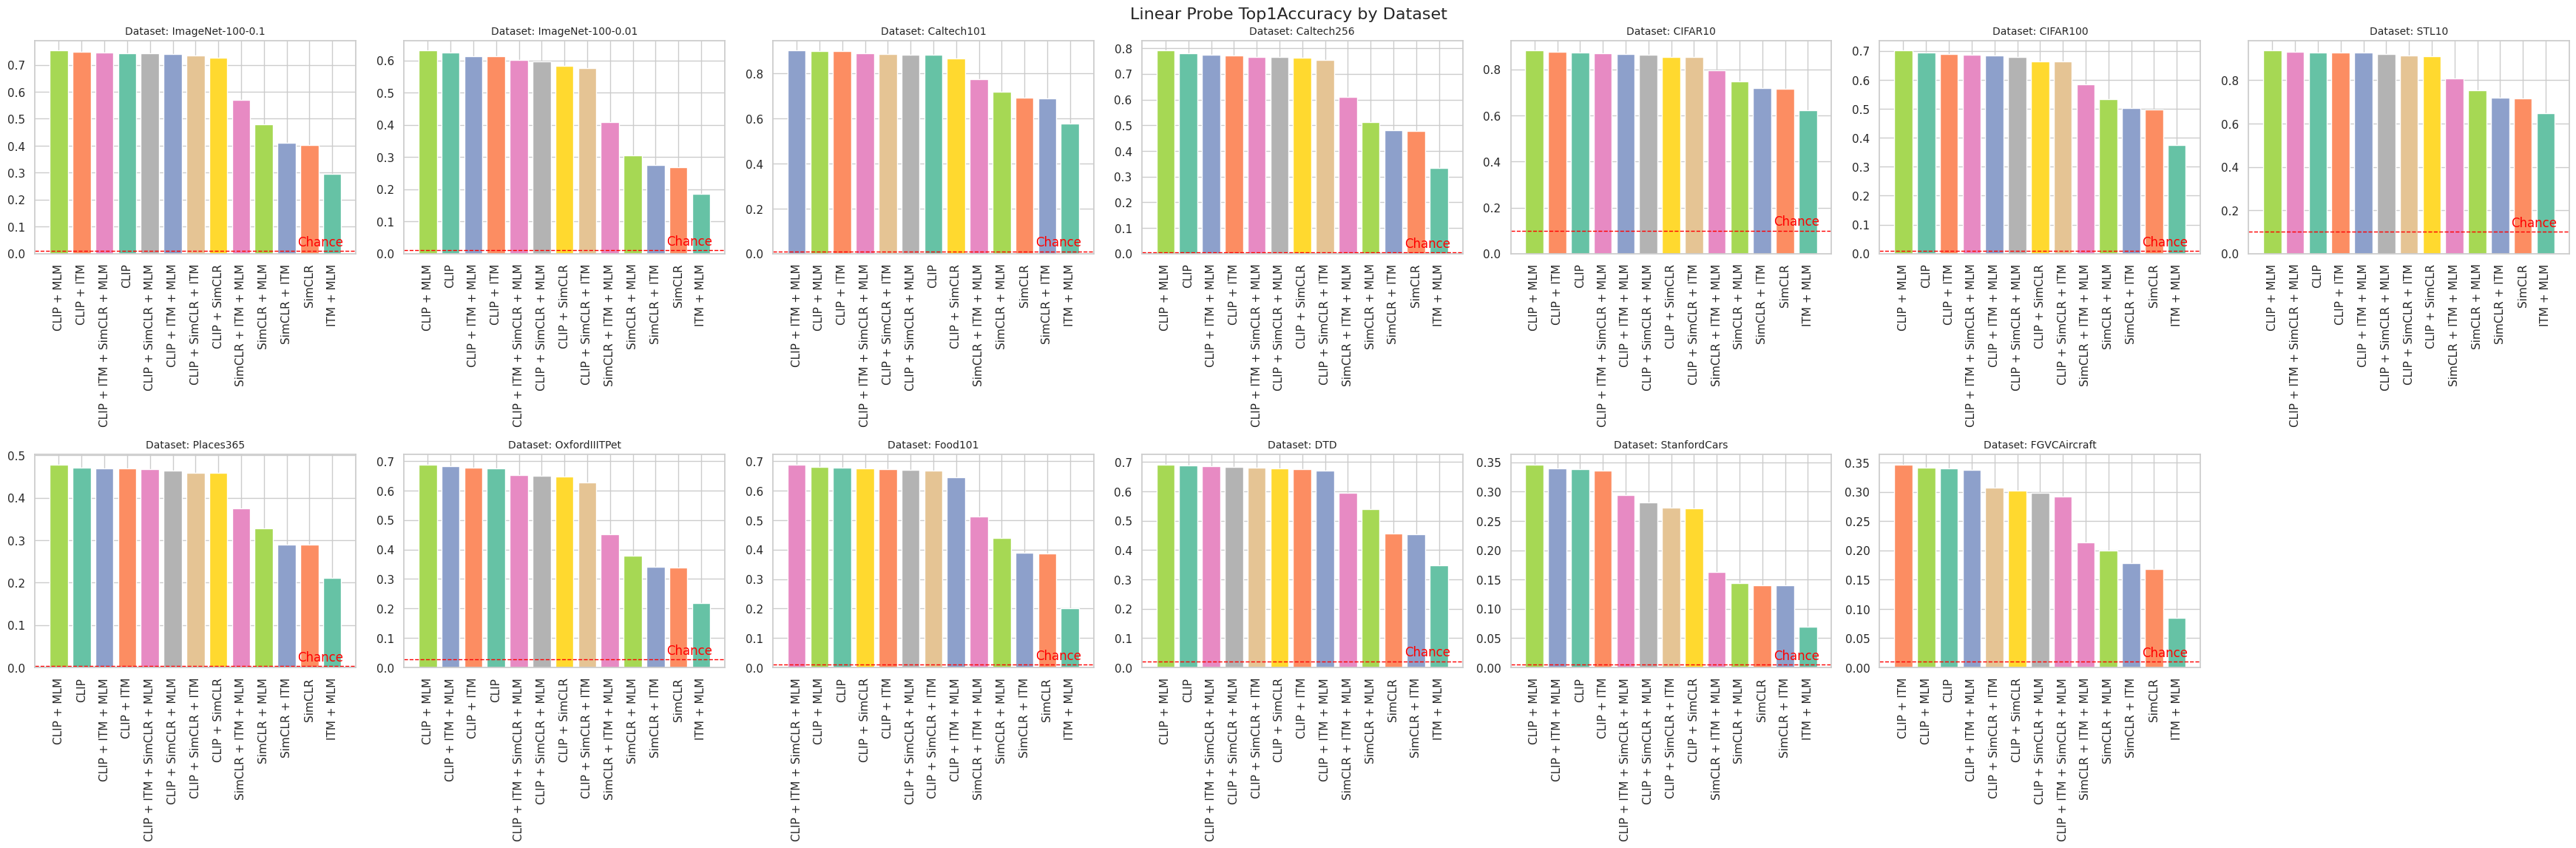

In [146]:
if task == "zeroshot":
    # method_notes = "1_templates"
    method_notes = "18_templates"
elif task == "linear_probe":
    method_notes = "last_image_layer"

plot_classification_results(
    task,
    csv_path=csv_path,
    group_by='dataset',
    has_clip=None,
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes=method_notes,
    adapt_ylim=False,
    random_chance_dict=random_chance_dict,
    sort_bars=True,
    group_order=dataset_order
)


### Average of datasets

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

def plot_average_performance_across_subsets(
    csv_path='model_results.csv',
    dataset_subsets=None,  # dict with keys as subset names, values as list of dataset names
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes='1_templates',
    require_clip=True,
    adapt_ylim=True,
    random_chance_dict=None,
    sort_bars=False,
    error_type=None,  # 'std' or 'sem' or None
):
    if dataset_subsets is None:
        raise ValueError("You must provide a dictionary of dataset subsets.")

    df = pd.read_csv(csv_path)

    # Apply filters
    df_filtered = df[
        (df['metric'] == metric) &
        (df['dataset_fraction'] == dataset_fraction) &
        (df['method_notes'] == method_notes)
    ]
    if require_clip:
        df_filtered = df_filtered[df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]

    if df_filtered.empty:
        print("No data after filtering. Check your filters or exclusions.")
        return

    n_subsets = len(dataset_subsets)
    n_cols = min(3, n_subsets)
    n_rows = math.ceil(n_subsets / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharey=not adapt_ylim)
    axes = axes.flatten()

    shared_ylim = None
    if not adapt_ylim:
        all_scores = []
        for datasets in dataset_subsets.values():
            subset_df = df_filtered[df_filtered['dataset'].isin(datasets)]
            avg_df = subset_df.groupby('model_name')['score'].mean()
            all_scores.extend(avg_df.values)
        shared_ylim = (min(all_scores), max(all_scores))

    for i, (subset_name, datasets) in enumerate(dataset_subsets.items()):
        subset_df = df_filtered[df_filtered['dataset'].isin(datasets)]

        if subset_df.empty:
            print(f"No data for subset: {subset_name}")
            continue

        grouped = subset_df.groupby('model_name')['score']
        avg_df = grouped.mean().reset_index(name='mean')

        if error_type == 'std':
            avg_df['error'] = grouped.std().reset_index(drop=True)
        elif error_type == 'sem':
            avg_df['error'] = grouped.sem().reset_index(drop=True)
        else:
            avg_df['error'] = None

        x = avg_df['model_name']
        y = avg_df['mean']
        yerr = avg_df['error'] if error_type else None

        ylim = None
        if adapt_ylim:
            upper = y + (yerr if yerr is not None else 0)
            ylim = (0, upper.max() * 1.05)  # add small margin on top
        else:
            ylim = shared_ylim


        # Determine chance level if available
        chance_level = None
        if random_chance_dict:
            all_chances = [random_chance_dict[d] for d in datasets if d in random_chance_dict]
            if all_chances:
                chance_level = sum(all_chances) / len(all_chances)

        plot_bar_chart(
            x=x,
            y=y,
            ax=axes[i],
            title=f"{subset_name}: Avg {metric}",
            # xlabel="Model",
            ylabel=metric if i % n_cols == 0 else "",
            ylim=ylim,
            chance_level=chance_level,
            sort_bars=sort_bars,
            yerr=yerr,
        )
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='right')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle(f"Average Linear Probe {metric} Across Dataset Subsets", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/tmp/ipykernel_2976435/2867193366.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_2976435/2867193366.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='right')
/tmp/ipykernel_2976435/2867193366.py:100: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90, ha='right')


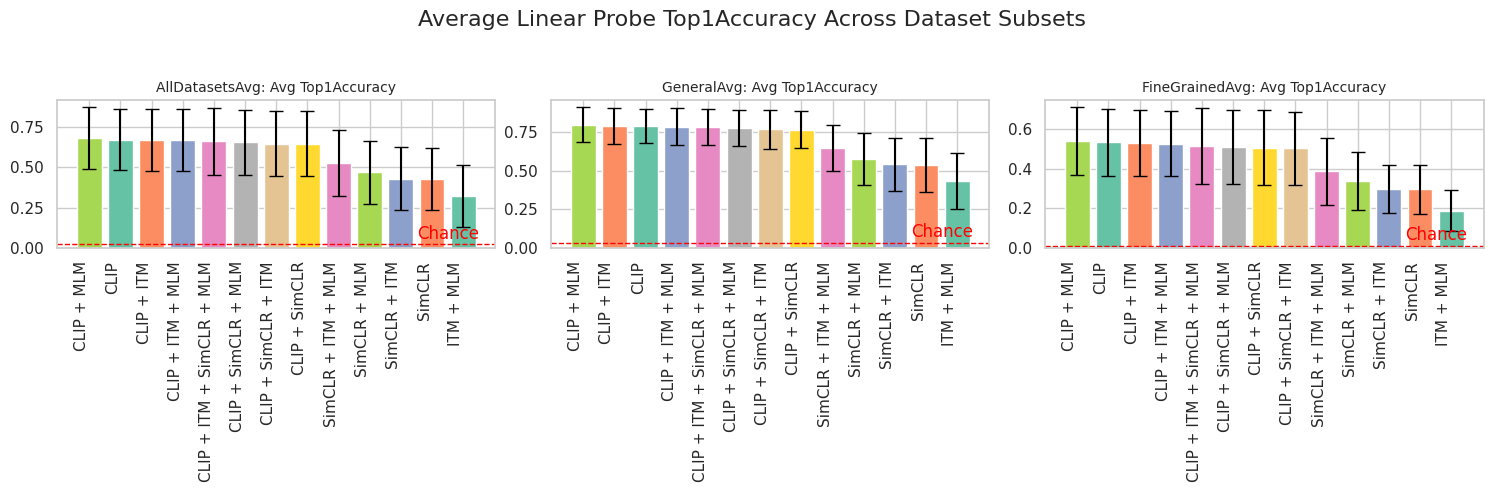

In [148]:
dataset_subsets_dict = dict(zip(subset_names, dataset_subsets))

if task == "zeroshot":
    # method_notes = "1_templates"
    method_notes = "18_templates"
elif task == "linear_probe":
    method_notes = "last_image_layer"

plot_average_performance_across_subsets(
    csv_path=csv_path,
    dataset_subsets=dataset_subsets_dict,
    require_clip=False,
    metric='Top1Accuracy',
    method_notes=method_notes,
    sort_bars=True,
    random_chance_dict=random_chance_dict,
    error_type='std',  # or 'std' or None
)


## Table

In [10]:
import pandas as pd

require_clip = True  # Set to True if you want to filter for CLIP models

# Define your dataset subsets and names
dataset_subsets = [
    ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10", "Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"],
    ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"],
    ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]
]
subset_names = ["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"]

# Load and filter your results
df = pd.read_csv(csv_path)
df_filtered = df[
    (df['metric'] == 'Top1Accuracy') &
    (df['dataset_fraction'] == '1-aug') &
    (df['method_notes'] == '1_templates')
]
if require_clip:
    df_filtered = df_filtered[df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]

# Convert scores to percentages
df_filtered = df_filtered.copy()
df_filtered['score'] = df_filtered['score'] * 100

# Add average rows for each subset
avg_rows = []
for subset, subset_name in zip(dataset_subsets, subset_names):
    subset_df = df_filtered[df_filtered['dataset'].isin(subset)]
    grouped = subset_df.groupby('model_name')['score'].mean().reset_index()
    grouped['dataset'] = subset_name
    avg_rows.append(grouped)
avg_df = pd.concat(avg_rows, ignore_index=True)

# Merge with original filtered table for pivot
df_table = pd.concat([df_filtered, avg_df], ignore_index=True)

# Pivot to get models as columns, datasets as rows (including averages)
table = df_table.pivot_table(
    index='model_name', columns='dataset', values='score', aggfunc='first'
)

# Move average columns (subset_names) to the front
avg_cols = [name for name in subset_names if name in table.columns]
other_cols = [col for col in table.columns if col not in avg_cols]
new_columns = avg_cols + other_cols
table = table.reindex(columns=new_columns)

# Reorder index so that average rows are at the bottom in the order of subset_names
other_rows = [idx for idx in table.index if idx not in subset_names]
new_index = other_rows + subset_names
table = table.reindex(new_index)

# Display as a pandas table in notebook
display(table.style.format("{:.2f}"))

# Export to LaTeX
latex_table = table.to_latex(float_format="%.2f")
print(latex_table)

\begin{tabular}{lrrrrrrrrrrrrrrr}
\toprule
dataset & AllDatasetsAvg & GeneralAvg & FineGrainedAvg & CIFAR10 & CIFAR100 & Caltech101 & Caltech256 & DTD & FGVCAircraft & Food101 & ImageNet & OxfordIIITPet & Places365 & STL10 & StanfordCars \\
model_name &  &  &  &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
CLIP & 22.43 & 36.14 & 8.72 & 48.14 & 14.30 & 40.08 & 32.07 & 13.94 & 1.50 & 13.66 & 11.58 & 7.91 & 14.51 & 70.70 & 0.82 \\
CLIP + ITM & 21.80 & 34.80 & 8.79 & 42.24 & 17.21 & 39.26 & 30.53 & 17.87 & 1.14 & 13.04 & 11.48 & 6.09 & 13.82 & 68.08 & 0.79 \\
CLIP + ITM + MLM & 26.17 & 42.75 & 9.59 & 58.13 & 21.18 & 47.82 & 37.86 & 15.05 & 1.35 & 13.04 & 13.44 & 8.21 & 19.15 & 78.08 & 0.76 \\
CLIP + ITM + SimCLR + MLM & 22.33 & 34.87 & 9.79 & 46.34 & 10.88 & 40.05 & 30.26 & 18.03 & 0.90 & 12.97 & 11.29 & 8.78 & 17.43 & 70.40 & 0.63 \\
CLIP + MLM & 24.14 & 38.84 & 9.44 & 44.64 & 18.08 & 48.83 & 35.95 & 15.37 & 1.29 & 13.51 & 12.43 & 7.72 & 17.89 & 73.10 & 0.85 \\
CLIP + SimCLR & 19.97 & 31

In [143]:
def make_accuracy_table(
    csv_path,
    metric,
    dataset_fraction,
    method_notes,
    dataset_subsets,
    subset_names,
    random_chance_dict=None,
    require_clip=True,
    
):
    """
    Create a table of Top-1 accuracy (in %) for each model and dataset, 
    including average rows for specified dataset subsets at the bottom,
    and a column with chance probabilities.

    Args:
        csv_path (str): Path to the CSV file.
        dataset_subsets (list of list): Each list contains dataset names for a subset.
        subset_names (list of str): Names for each subset (used as new dataset name).
        random_chance_dict (dict): Dict mapping dataset names to chance probabilities.
        require_clip (bool): If True, only include models with 'CLIP' in their name.
        metric (str): Metric to filter for.
        dataset_fraction (str): Dataset fraction to filter for.
        method_notes (str): Method notes to filter for.

    Returns:
        pd.DataFrame: Pivot table with datasets as rows and models as columns, plus a 'Chance' column.
    """
    import pandas as pd

    # Load and filter your results
    df = pd.read_csv(csv_path)
    df_filtered = df[
        (df['metric'] == metric) &
        (df['dataset_fraction'] == dataset_fraction) &
        (df['method_notes'] == method_notes)
    ]
    if require_clip:
        df_filtered = df_filtered[df_filtered['model_name'].str.contains('CLIP', case=False, na=False)]

    # Convert scores to percentages
    df_filtered = df_filtered.copy()
    df_filtered['score'] = df_filtered['score'] * 100

    # Add average rows for each subset
    avg_rows = []
    for subset, subset_name in zip(dataset_subsets, subset_names):
        subset_df = df_filtered[df_filtered['dataset'].isin(subset)]
        grouped = subset_df.groupby('model_name')['score'].mean().reset_index()
        grouped['dataset'] = subset_name
        avg_rows.append(grouped)
    avg_df = pd.concat(avg_rows, ignore_index=True)

    # Merge with original filtered table for pivot
    df_table = pd.concat([df_filtered, avg_df], ignore_index=True)

    # Pivot to get models as columns, datasets as rows (including averages)
    table = df_table.pivot_table(
        index='dataset', columns='model_name', values='score', aggfunc='first'
    )

    # Add chance column (in percent)
    if random_chance_dict is not None:
        chance_col = []
        for idx in table.index:
            if idx in random_chance_dict:
                chance_col.append(100 * random_chance_dict[idx])
            else:
                # For average rows, show mean chance of the subset if possible
                if idx in subset_names:
                    # Find which subset this is
                    subset_idx = subset_names.index(idx)
                    subset = dataset_subsets[subset_idx]
                    chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
                    chance_col.append(100 * sum(chances) / len(chances) if chances else None)
                else:
                    chance_col.append(None)
        table.insert(0, "Chance", chance_col)

    # Reorder index so that average rows are at the bottom in the order of subset_names
    other_rows = [idx for idx in table.index if idx not in subset_names]
    new_index = other_rows + subset_names
    table = table.reindex(new_index)

    return table

# Example usage:
# table = make_accuracy_table(csv_path, dataset_subsets, subset_names, random_chance_dict=random_chance_dict)
# display(table.style.format("{:.2f}"))
# latex_table = table.to_latex(float_format="%.2f")
# print(latex_table)

In [150]:
if task == "zeroshot":
    # method_notes = "1_templates"
    method_notes = "18_templates"
elif task == "linear_probe":
    method_notes = "last_image_layer"


table = make_accuracy_table(
    csv_path, 
    metric='Top1Accuracy',
    dataset_fraction='1-aug',
    method_notes=method_notes,
    dataset_subsets=dataset_subsets, 
    subset_names=subset_names, 
    random_chance_dict=random_chance_dict, 
    require_clip=False
)
# Display the table
display(table.style.format("{:.2f}"))

## Delta from CLIP baseline

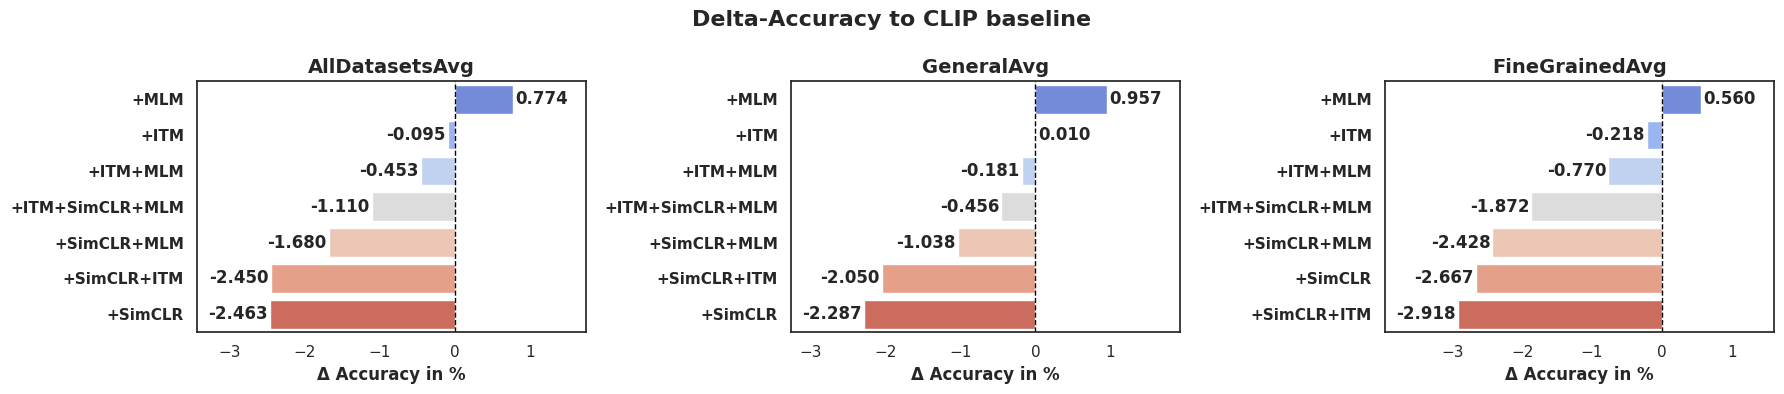

In [152]:
def plot_model_deltas(df, datasets, figsize=(6, 4), show_values=True):
    """
    Plotte Delta-Accuracy zu CLIP für ein oder mehrere Datasets.

    Parameters:
    - df: DataFrame mit Modell-Ergebnissen. Index = Datasetname, Spalten = Modellnamen.
    - datasets: str oder Liste von Datasetnamen (muss im Index von df enthalten sein).
    - figsize: Größe des gesamten Plots (pro Subplot).
    - show_values: Zeige Werte neben den Balken.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    sns.set(style="white")

    # Falls nur ein Datasetname übergeben wird
    if isinstance(datasets, str):
        datasets = [datasets]

    # Only keep models with 'CLIP' in their name
    clip_cols = [col for col in df.columns if "CLIP" in col]
    df = df[clip_cols]

    num_plots = len(datasets)
    fig, axes = plt.subplots(1, num_plots, figsize=(figsize[0] * num_plots, figsize[1]), sharex=False)
    fig.suptitle("Delta-Accuracy to CLIP baseline", fontsize=16, fontweight='bold')

    if num_plots == 1:
        axes = [axes]  # damit es iterierbar ist

    for ax, dataset_name in zip(axes, datasets):
        if dataset_name not in df.index:
            ax.set_visible(False)
            print(f"⚠️ Dataset '{dataset_name}' nicht gefunden.")
            continue

        row = df.loc[dataset_name]
        baseline = row['CLIP']
        delta = row.drop('CLIP') - baseline
        delta = delta.sort_values(ascending=False)  # von oben (positiv) nach unten (negativ)

        # Modellnamen bereinigen: "CLIP " entfernen
        clean_labels = [name.replace("CLIP ", "").replace(" ", "") for name in delta.index]

        # Berechnung der X-Limits für Text-Offset
        min_val, max_val = delta.min(), delta.max()
        range_padding = (max_val - min_val) * 0.30
        x_min = min_val - range_padding
        x_max = max_val + range_padding
        ax.set_xlim(x_min, x_max)

        # Balkenplot
        sns.barplot(x=delta.values, y=clean_labels, ax=ax, palette="coolwarm", orient='h', hue=clean_labels, legend=False)

        # Titel & Achsen
        ax.set_title(dataset_name, fontsize=14, fontweight='bold')
        ax.set_xlabel("Δ Accuracy in %", fontsize=12, fontweight='bold')
        ax.set_ylabel("")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)

        # Format der Y-Tick-Labels
        for label in ax.get_yticklabels():
            label.set_fontsize(11)
            label.set_fontweight('bold')

        # Werte an die Balken schreiben
        if show_values:
            for i, val in enumerate(delta.values):
                ha = 'left' if val >= 0 else 'right'
                offset = 0.005 * (x_max - x_min)
                x_pos = val + offset if val >= 0 else val - offset
                ax.text(x_pos, i, f"{val:.3f}", va='center', ha=ha, fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()


plot_model_deltas(table, ["AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"])


## Accuracy vs. #templates

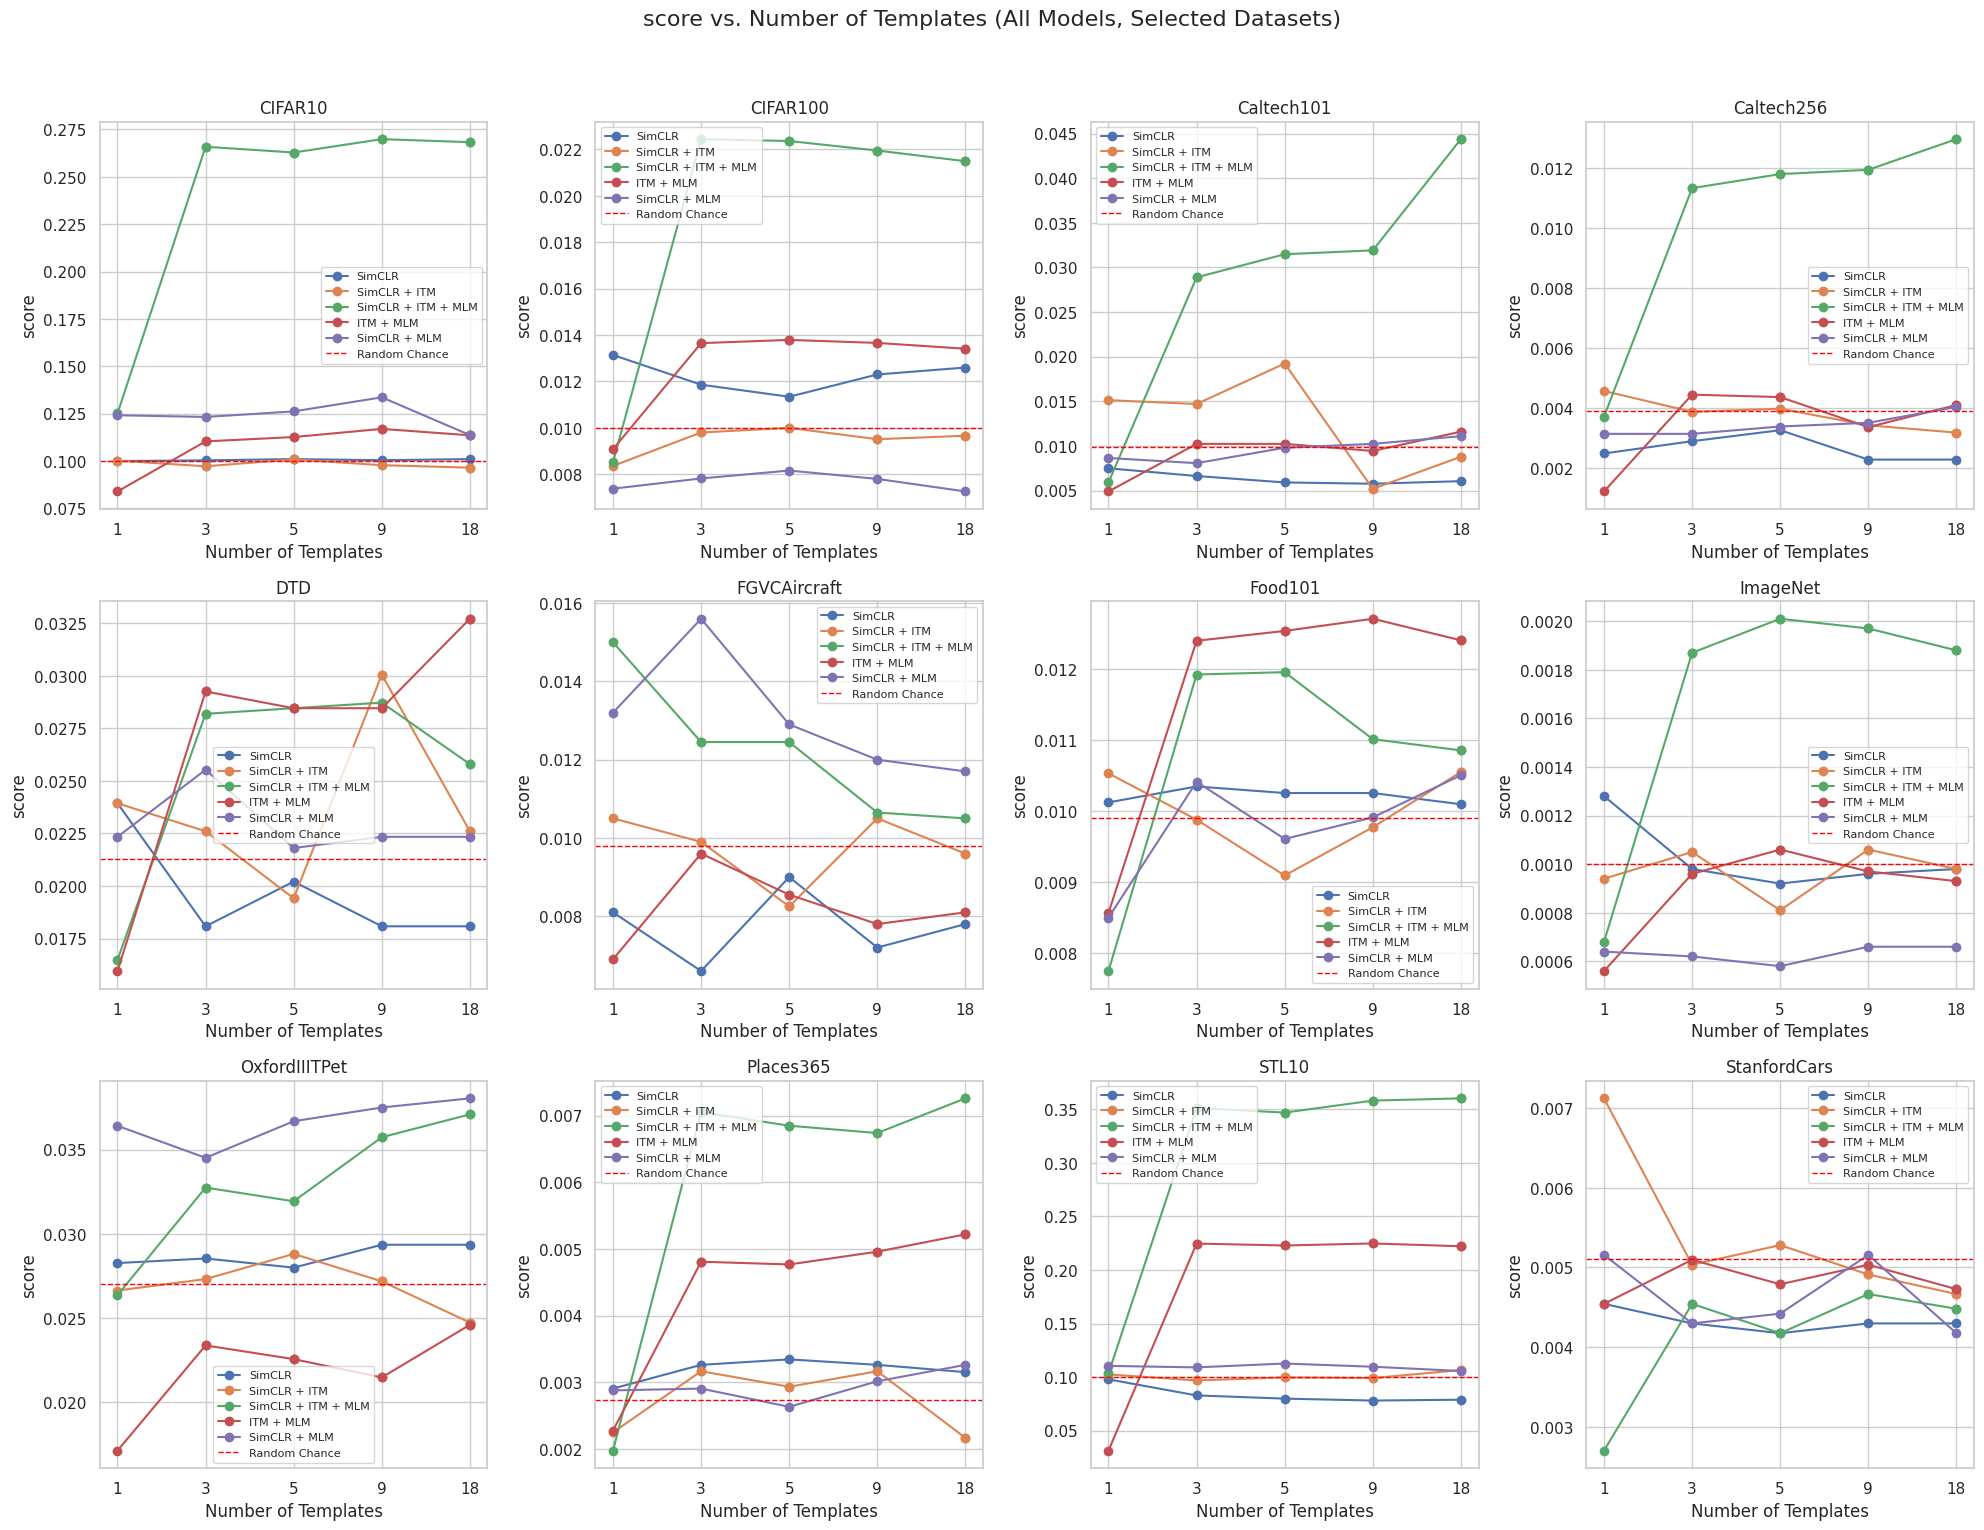

In [19]:
import matplotlib.gridspec as gridspec

def plot_accuracy_vs_templates_all_models_all_datasets(
    df_with_avgs,
    dataset_fraction=None,
    has_clip=None,
    metric="Top1Accuracy",
    accuracy_col='score',
    templates_num_col='method_notes',
    model_col='model_name',
    dataset_col='dataset',
    random_chance_dict=None,
    dataset_subsets=None,
    subset_names=None,
    datasets_to_plot="all",
    exclude_models=None,
    templates_dict=None,
):
    import numpy as np
    import matplotlib.pyplot as plt

    df = df_with_avgs.copy()
    df['Templates_num'] = df[templates_num_col].str.extract(r'(\d+)').astype(float)

    if dataset_fraction is not None:
        df = df[df.get('dataset_fraction', None) == dataset_fraction]
    if metric is not None and 'metric' in df.columns:
        df = df[df['metric'] == metric]
    if has_clip is True:
        df = df[df[model_col].str.contains('CLIP', case=False, na=False)]
    elif has_clip is False:
        df = df[~df[model_col].str.contains('CLIP', case=False, na=False)]
    if exclude_models is not None:
        df = df[~df[model_col].isin(exclude_models)]

    avg_chance_map = {}
    if random_chance_dict and dataset_subsets and subset_names:
        for subset, name in zip(dataset_subsets, subset_names):
            chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
            avg_chance_map[name] = sum(chances) / len(chances) if chances else None

    all_datasets = sorted(df[dataset_col].unique())
    if datasets_to_plot == "average" and subset_names is not None:
        datasets = [d for d in all_datasets if d in subset_names]
    elif datasets_to_plot == "actual" and subset_names is not None:
        datasets = [d for d in all_datasets if d not in subset_names]
    else:
        datasets = all_datasets

    n = len(datasets)
    if n < 4:
        nrows = 1
        ncols = n
    else:
        nrows = 3
        ncols = (n + nrows - 1) // nrows

    # Add 1 extra row for the template text
    fig = plt.figure(figsize=(5 * ncols, 5 * nrows + 2))
    gs = gridspec.GridSpec(nrows + 1, ncols, height_ratios=[4]*nrows + [1])

    axes = []
    for i in range(n):
        row = i // ncols
        col = i % ncols
        ax = fig.add_subplot(gs[row, col])
        axes.append(ax)

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        template_nums = sorted(df[df[dataset_col] == dataset]['Templates_num'].dropna().unique())
        template_pos = {num: idx for idx, num in enumerate(template_nums)}
        for model in df[model_col].unique():
            if exclude_models is not None and model in exclude_models:
                continue
            sub = df[(df[model_col] == model) & (df[dataset_col] == dataset)].sort_values('Templates_num')
            if not sub.empty:
                x_vals = [template_pos[num] for num in sub['Templates_num']]
                ax.plot(x_vals, sub[accuracy_col], marker='o', label=model)
        chance = None
        if random_chance_dict:
            if dataset in random_chance_dict:
                chance = random_chance_dict[dataset]
            elif avg_chance_map and dataset in avg_chance_map:
                chance = avg_chance_map[dataset]
        if chance is not None:
            ax.axhline(chance, color='red', linestyle='--', linewidth=1, label='Random Chance')
        ax.set_xticks(range(len(template_nums)))
        ax.set_xticklabels([str(int(t)) for t in template_nums])
        ax.set_xlabel('Number of Templates')
        ax.set_ylabel(accuracy_col)
        ax.set_title(dataset)
        ax.grid(True)
        ax.legend(fontsize=8)

    # --- Add template text in a single axes below all subplots ---
    if templates_dict is not None:
        text_ax = fig.add_subplot(gs[-1, :])
        texts = []
        for tnum in sorted(templates_dict.keys()):
            template_text = templates_dict[tnum]
            if isinstance(template_text, list):
                template_text = " | ".join(template_text)
            texts.append(f"{tnum}: {template_text}")
        text_ax.text(
            0.5, 0.5, "\n".join(texts),
            ha='center', va='center', fontsize=9, color='dimgray', wrap=True
        )
        text_ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle(f"{accuracy_col} vs. Number of Templates (All Models, Selected Datasets)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


plot_accuracy_vs_templates_all_models_all_datasets(
    df_with_avgs,
    dataset_fraction='1-aug',
    has_clip=False,
    random_chance_dict=random_chance_dict,
    dataset_subsets=dataset_subsets,
    subset_names=subset_names,
    # exclude_models=["SimCLR + ITM", "SimCLR"],
    datasets_to_plot="actual",
    # templates_dict=templates_dict
)

In [ ]:
def plot_accuracy_vs_templates_all_models_all_datasets(
    df_with_avgs,
    dataset_fraction=None,
    has_clip=None,
    metric="Top1Accuracy",
    accuracy_col='score',
    templates_num_col='method_notes',
    model_col='model_name',
    dataset_col='dataset',
    random_chance_dict=None,
    dataset_subsets=None,
    subset_names=None,
    datasets_to_plot="all",
    exclude_models=None,
    templates_dict=None,  # <-- NEW ARGUMENT
):
    import numpy as np

    df = df_with_avgs.copy()
    df['Templates_num'] = df[templates_num_col].str.extract(r'(\d+)').astype(float)

    if dataset_fraction is not None:
        df = df[df.get('dataset_fraction', None) == dataset_fraction]
    if metric is not None and 'metric' in df.columns:
        df = df[df['metric'] == metric]
    if has_clip is True:
        df = df[df[model_col].str.contains('CLIP', case=False, na=False)]
    elif has_clip is False:
        df = df[~df[model_col].str.contains('CLIP', case=False, na=False)]
    if exclude_models is not None:
        df = df[~df[model_col].isin(exclude_models)]

    avg_chance_map = {}
    if random_chance_dict and dataset_subsets and subset_names:
        for subset, name in zip(dataset_subsets, subset_names):
            chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
            avg_chance_map[name] = sum(chances) / len(chances) if chances else None

    all_datasets = sorted(df[dataset_col].unique())
    if datasets_to_plot == "average" and subset_names is not None:
        datasets = [d for d in all_datasets if d in subset_names]
    elif datasets_to_plot == "actual" and subset_names is not None:
        datasets = [d for d in all_datasets if d not in subset_names]
    else:
        datasets = all_datasets

    n = len(datasets)
    if n < 4:
        nrows = 1
        ncols = n
    else:
        nrows = 3
        ncols = (n + nrows - 1) // nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        template_nums = sorted(df[df[dataset_col] == dataset]['Templates_num'].dropna().unique())
        template_pos = {num: idx for idx, num in enumerate(template_nums)}
        for model in df[model_col].unique():
            if exclude_models is not None and model in exclude_models:
                continue
            sub = df[(df[model_col] == model) & (df[dataset_col] == dataset)].sort_values('Templates_num')
            if not sub.empty:
                x_vals = [template_pos[num] for num in sub['Templates_num']]
                ax.plot(x_vals, sub[accuracy_col], marker='o', label=model)
        chance = None
        if random_chance_dict:
            if dataset in random_chance_dict:
                chance = random_chance_dict[dataset]
            elif avg_chance_map and dataset in avg_chance_map:
                chance = avg_chance_map[dataset]
        if chance is not None:
            ax.axhline(chance, color='red', linestyle='--', linewidth=1, label='Random Chance')
        ax.set_xticks(range(len(template_nums)))
        ax.set_xticklabels([str(int(t)) for t in template_nums])
        ax.set_xlabel('Number of Templates')
        ax.set_ylabel(accuracy_col)
        ax.set_title(dataset)
        ax.grid(True)
        ax.legend(fontsize=8)

        # --- Add template text below each x-tick ---
        if templates_dict is not None:
            for idx, tnum in enumerate(template_nums):
                template_text = templates_dict.get(int(tnum), None)
                if template_text is not None:
                    # If it's a list, join with newlines
                    if isinstance(template_text, list):
                        template_text = "\n".join(template_text)
                    ax.text(
                        idx, ax.get_ylim()[0] - 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                        template_text,
                        ha='center', va='top', fontsize=8, rotation=0, color='dimgray',
                        wrap=True, clip_on=False, transform=ax.get_xaxis_transform()
                    )
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"{accuracy_col} vs. Number of Templates (All Models, Selected Datasets)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

In [ ]:
def plot_accuracy_vs_templates_all_models_all_datasets(
    df_with_avgs,
    dataset_fraction=None,
    has_clip=None,
    metric="Top1Accuracy",
    accuracy_col='score',
    templates_num_col='method_notes',
    model_col='model_name',
    dataset_col='dataset',
    random_chance_dict=None,
    dataset_subsets=None,
    subset_names=None,
    datasets_to_plot="all",
    exclude_models=None,
    templates_dict=None,  # <-- NEW ARGUMENT
):
    import numpy as np

    df = df_with_avgs.copy()
    df['Templates_num'] = df[templates_num_col].str.extract(r'(\d+)').astype(float)

    if dataset_fraction is not None:
        df = df[df.get('dataset_fraction', None) == dataset_fraction]
    if metric is not None and 'metric' in df.columns:
        df = df[df['metric'] == metric]
    if has_clip is True:
        df = df[df[model_col].str.contains('CLIP', case=False, na=False)]
    elif has_clip is False:
        df = df[~df[model_col].str.contains('CLIP', case=False, na=False)]
    if exclude_models is not None:
        df = df[~df[model_col].isin(exclude_models)]

    avg_chance_map = {}
    if random_chance_dict and dataset_subsets and subset_names:
        for subset, name in zip(dataset_subsets, subset_names):
            chances = [random_chance_dict[d] for d in subset if d in random_chance_dict]
            avg_chance_map[name] = sum(chances) / len(chances) if chances else None

    all_datasets = sorted(df[dataset_col].unique())
    if datasets_to_plot == "average" and subset_names is not None:
        datasets = [d for d in all_datasets if d in subset_names]
    elif datasets_to_plot == "actual" and subset_names is not None:
        datasets = [d for d in all_datasets if d not in subset_names]
    else:
        datasets = all_datasets

    n = len(datasets)
    if n < 4:
        nrows = 1
        ncols = n
    else:
        nrows = 3
        ncols = (n + nrows - 1) // nrows

    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        template_nums = sorted(df[df[dataset_col] == dataset]['Templates_num'].dropna().unique())
        template_pos = {num: idx for idx, num in enumerate(template_nums)}
        for model in df[model_col].unique():
            if exclude_models is not None and model in exclude_models:
                continue
            sub = df[(df[model_col] == model) & (df[dataset_col] == dataset)].sort_values('Templates_num')
            if not sub.empty:
                x_vals = [template_pos[num] for num in sub['Templates_num']]
                ax.plot(x_vals, sub[accuracy_col], marker='o', label=model)
        chance = None
        if random_chance_dict:
            if dataset in random_chance_dict:
                chance = random_chance_dict[dataset]
            elif avg_chance_map and dataset in avg_chance_map:
                chance = avg_chance_map[dataset]
        if chance is not None:
            ax.axhline(chance, color='red', linestyle='--', linewidth=1, label='Random Chance')
        ax.set_xticks(range(len(template_nums)))
        ax.set_xticklabels([str(int(t)) for t in template_nums])
        ax.set_xlabel('Number of Templates')
        ax.set_ylabel(accuracy_col)
        ax.set_title(dataset)
        ax.grid(True)
        ax.legend(fontsize=8)

        # --- Add template text below each x-tick ---
        if templates_dict is not None:
            for idx, tnum in enumerate(template_nums):
                template_text = templates_dict.get(int(tnum), None)
                if template_text is not None:
                    # If it's a list, join with newlines
                    if isinstance(template_text, list):
                        template_text = "\n".join(template_text)
                    ax.text(
                        idx, ax.get_ylim()[0] - 0.02 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                        template_text,
                        ha='center', va='top', fontsize=8, rotation=0, color='dimgray',
                        wrap=True, clip_on=False, transform=ax.get_xaxis_transform()
                    )
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.suptitle(f"{accuracy_col} vs. Number of Templates (All Models, Selected Datasets)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

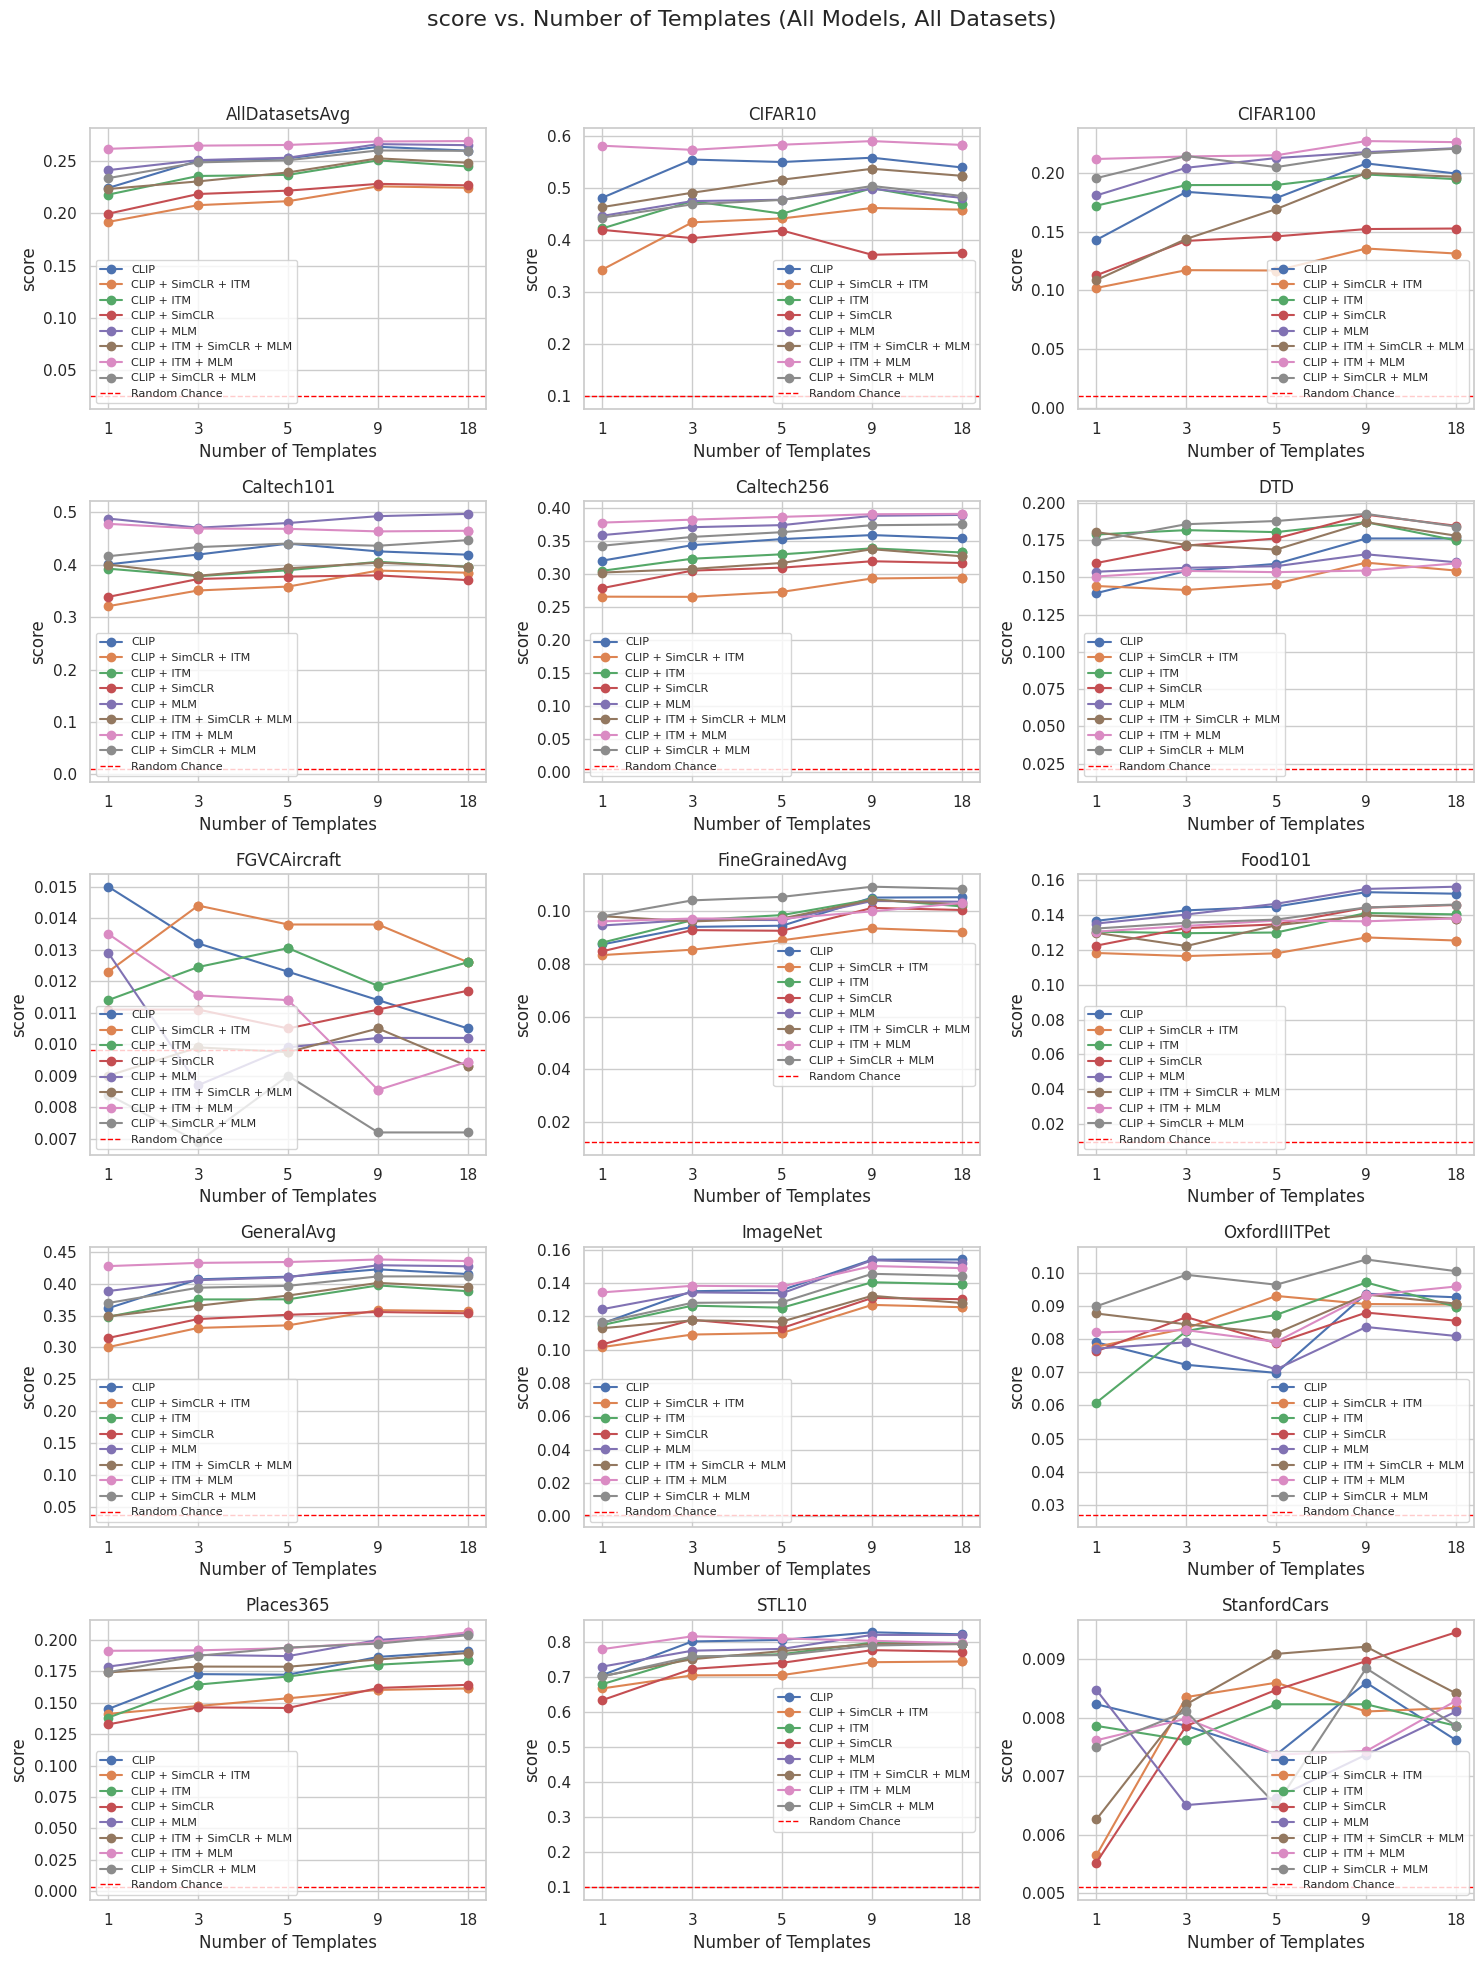

In [22]:
plot_accuracy_vs_templates_all_models_all_datasets(
    df_with_avgs,
    dataset_fraction='1-aug',
    require_clip=True,
    random_chance_dict=random_chance_dict,
    dataset_subsets=dataset_subsets,
    subset_names=subset_names
)

In [6]:
df_with_avgs

model_id         dataset    method mode        metric     score  \
0     93t3xgrr      Caltech101  zeroshot  NaN  Top1Accuracy  0.474715   
1     93t3xgrr      Caltech101  zeroshot  NaN  Top3Accuracy  0.702204   
2     93t3xgrr      Caltech101  zeroshot  NaN  Top5Accuracy  0.767325   
3     93t3xgrr      Caltech256  zeroshot  NaN  Top1Accuracy  0.346539   
4     93t3xgrr      Caltech256  zeroshot  NaN  Top3Accuracy  0.500511   
...        ...             ...       ...  ...           ...       ...   
5910       NaN  FineGrainedAvg       NaN  NaN  Top5Accuracy  0.066119   
5911       NaN  FineGrainedAvg       NaN  NaN  Top5Accuracy  0.065345   
5912       NaN  FineGrainedAvg       NaN  NaN  Top5Accuracy  0.063746   
5913       NaN  FineGrainedAvg       NaN  NaN  Top5Accuracy  0.065949   
5914       NaN  FineGrainedAvg       NaN  NaN  Top5Accuracy  0.065291   

      method_notes  dataset_notes    model_name dataset_fraction  
0      1_templates            NaN    CLIP + ITM              1.0  
1      1_templates            NaN    CLIP + ITM              1.0  
2      1_templates            NaN    CLIP + ITM              1.0  
3      1_templates            NaN    CLIP + ITM              1.0  
4      1_templates            NaN    CLIP + ITM              1.0  
...            ...            ...           ...              ...  
5910  18_templates            NaN  SimCLR + MLM            1-aug  
5911   1_templates            NaN  SimCLR + MLM            1-aug  
5912   3_templates            NaN  SimCLR + MLM            1-aug  
5913   5_templates            NaN  SimCLR + MLM            1-aug  
5914   9_templates            NaN  SimCLR + MLM            1-aug  

[5915 rows x 10 columns]

In [17]:
def make_template_table(
    df_with_avgs,
    metric="Top1Accuracy",
    method_notes=None,
    dataset_fraction="1-aug",
    score_col="score",
    dataset_col="dataset",
    model_col="model_name",
    method_notes_col="method_notes",
    avg_names=("AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"),
    swap_axes=False,
    which_datasets="all"  # "all", "average", or "actual"
):
    """
    Returns a MultiIndex table:
      - Default: rows=datasets, columns=(model, template_amount)
      - If swap_axes=True: rows=(model, template_amount), columns=datasets
    Scores are in percent (2 decimals). Average rows (avg_names) are placed first.
    which_datasets: "all" (default), "average" (only avg_names), or "actual" (exclude avg_names)
    """
    # Filter
    df = df_with_avgs.copy()
    df = df[df["metric"] == metric]
    if method_notes is not None:
        if isinstance(method_notes, (list, tuple)):
            df = df[df[method_notes_col].isin(method_notes)]
        else:
            df = df[df[method_notes_col] == method_notes]
    if dataset_fraction is not None:
        df = df[df["dataset_fraction"] == dataset_fraction]

    # Extract template amount as int
    df = df.copy()
    df["template_amount"] = df[method_notes_col].str.extract(r"(\d+)").astype(float).astype("Int64")

    # Convert score to percent with 2 decimals
    df[score_col] = (df[score_col] * 100).round(2)

    if not swap_axes:
        table = df.pivot_table(
            index=dataset_col,
            columns=[model_col, "template_amount"],
            values=score_col,
            aggfunc="first"
        )
        table = table.sort_index(axis=1, level=[0,1])
        idx = list(table.index)
        avg_rows = [name for name in avg_names if name in idx]
        other_rows = [i for i in idx if i not in avg_rows]
        if which_datasets == "average":
            new_index = avg_rows
        elif which_datasets == "actual":
            new_index = other_rows
        else:
            new_index = avg_rows + other_rows
        table = table.reindex(new_index)
    else:
        table = df.pivot_table(
            index=[model_col, "template_amount"],
            columns=dataset_col,
            values=score_col,
            aggfunc="first"
        )
        table = table.sort_index(axis=0, level=[0,1])
        cols = list(table.columns)
        avg_cols = [name for name in avg_names if name in cols]
        other_cols = [c for c in cols if c not in avg_cols]
        if which_datasets == "average":
            new_cols = avg_cols
        elif which_datasets == "actual":
            new_cols = other_cols
        else:
            new_cols = avg_cols + other_cols
        table = table.reindex(columns=new_cols)

    return table

# Example usage:
# table = make_template_table(df_with_avgs, metric="Top1Accuracy", swap_axes=True, which_rows="average")
# display(table)

In [21]:
# Show all rows and columns in the notebook output
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

table = make_template_table(df_with_avgs, metric="Top1Accuracy", method_notes=None, dataset_fraction="1-aug", swap_axes=True, which_datasets="average")
display(table)

dataset                                    AllDatasetsAvg  GeneralAvg  \
model_name                template_amount                               
CLIP                      1                         22.43       36.14   
                          3                         25.03       40.67   
                          5                         25.26       41.09   
                          9                         26.37       42.24   
                          18                        26.00       41.50   
CLIP + ITM                1                         21.80       34.80   
                          3                         23.58       37.52   
                          5                         23.68       37.54   
                          9                         25.07       39.72   
                          18                        24.49       38.81   
CLIP + ITM + MLM          1                         26.17       42.75   
                          3                         26.48       43.26   
                          5                         26.54       43.39   
                          9                         26.88       43.79   
                          18                        26.91       43.54   
CLIP + ITM + SimCLR + MLM 1                         22.33       34.87   
                          3                         23.06       36.53   
                          5                         23.92       38.13   
                          9                         25.26       40.12   
                          18                        24.84       39.45   
CLIP + MLM                1                         24.14       38.84   
                          3                         25.10       40.54   
                          5                         25.32       41.00   
                          9                         26.62       42.89   
                          18                        26.53       42.72   
CLIP + SimCLR             1                         19.97       31.48   
                          3                         21.85       34.45   
                          5                         22.18       35.11   
                          9                         22.82       35.54   
                          18                        22.68       35.34   
CLIP + SimCLR + ITM       1                         19.18       30.04   
                          3                         20.79       33.05   
                          5                         21.17       33.45   
                          9                         22.58       35.84   
                          18                        22.44       35.68   
CLIP + SimCLR + MLM       1                         23.37       36.96   
                          3                         24.87       39.36   
                          5                         25.09       39.65   
                          9                         26.02       41.13   
                          18                        25.98       41.14   
ITM + MLM                 1                          1.55        2.18   
                          3                          3.74        6.07   
                          5                          3.72        6.08   
                          9                          3.75        6.15   
                          18                         3.78        6.10   
SimCLR                    1                          2.50        3.70   
                          3                          2.31        3.43   
                          5                          2.31        3.37   
                          9                          2.27        3.33   
                          18                         2.29        3.36   
SimCLR + ITM              1                          2.60        3.86   
                          3                          2.51        3.72   
                          5                          2.57 

In [39]:
def compute_template_score_increase_table(
    df,
    model_col="model_name",
    method_notes_col="method_notes",
    score_col="score",
    dataset_col="dataset",
    metric="Top1Accuracy",
    dataset_fraction="1-aug",
    method_notes_filter=None,
    which_datasets="all",  # "all", "average", or "actual"
    avg_names=("AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"),
    model_order=None,
):
    """
    Returns a MultiIndex columns DataFrame:
      - Rows: models (in model_order if given)
      - Columns: (dataset, [score/min_score, score/max_score, templates/min_templates, templates/max_templates, increase_pp])
    """
    df = df.copy()
    df = df[df["metric"] == metric]
    df = df[df["dataset_fraction"] == dataset_fraction]
    if method_notes_filter is not None:
        df = df[df[method_notes_col].isin(method_notes_filter)]

    # Extract template amount as int
    df["template_amount"] = df[method_notes_col].str.extract(r"(\d+)").astype(float).astype("Int64")
    # Convert score to percent if not already
    if df[score_col].max() <= 1.0:
        df[score_col] = df[score_col] * 100

    # Select datasets
    all_datasets = df[dataset_col].unique()
    if which_datasets == "average":
        datasets = [d for d in all_datasets if d in avg_names]
    elif which_datasets == "actual":
        datasets = [d for d in all_datasets if d not in avg_names]
    else:
        datasets = all_datasets

    # Determine model order
    models = list(df[model_col].unique())
    if model_order is not None:
        models = [m for m in model_order if m in models] + [m for m in models if m not in model_order]

    records = []
    for model in models:
        row = {"model_name": model}
        for dataset in datasets:
            sub = df[(df[model_col] == model) & (df[dataset_col] == dataset)]
            if sub.empty:
                vals = [None, None, None, None, None]
            else:
                idx_min = sub[score_col].idxmin()
                idx_max = sub[score_col].idxmax()
                min_score = sub.loc[idx_min, score_col]
                min_templates = sub.loc[idx_min, "template_amount"]
                max_score = sub.loc[idx_max, score_col]
                max_templates = sub.loc[idx_max, "template_amount"]
                increase_pp = max_score - min_score
                vals = [
                    round(min_score, 2),
                    int(min_templates),
                    round(max_score, 2),
                    int(max_templates),
                    round(increase_pp, 2)
                ]
            # Map to new column structure
            row.update({
                (dataset, "score", "min"): vals[0],
                (dataset, "score", "max"): vals[2],
                (dataset, "templates", "min"): vals[1],
                (dataset, "templates", "max"): vals[3],
                (dataset, "% increase", ""): vals[4],
            })
        records.append(row)
    # Build MultiIndex columns
    columns = []
    for dataset in datasets:
        columns.extend([
            (dataset, "score", "min"),
            (dataset, "score", "max"),
            (dataset, "templates", "min"),
            (dataset, "templates", "max"),
            (dataset, "% increase", ""),
        ])
    columns = pd.MultiIndex.from_tuples(columns, names=["dataset", "category", "stat"])
    result_df = pd.DataFrame(records).set_index("model_name")
    result_df = result_df.reindex(columns=columns)
    if model_order is not None:
        idx = [m for m in model_order if m in result_df.index] + [m for m in result_df.index if m not in model_order]
        result_df = result_df.reindex(idx)
    return result_df

# Example usage:
increases_table = compute_template_score_increase_table(df_with_avgs, which_datasets="average", model_order=model_order)
display(increases_table)

dataset                   AllDatasetsAvg                                  \
category                           score        templates     % increase   
stat                                 min    max       min max              
model_name                                                                 
CLIP                               22.43  26.37         1   9       3.93   
CLIP + ITM                         21.80  25.07         1   9       3.28   
CLIP + SimCLR                      19.97  22.82         1   9       2.85   
CLIP + MLM                         24.14  26.62         1   9       2.49   
CLIP + SimCLR + ITM                19.18  22.58         1   9       3.40   
CLIP + ITM + MLM                   26.17  26.91         1  18       0.74   
CLIP + SimCLR + MLM                23.37  26.02         1   9       2.65   
CLIP + ITM + SimCLR + MLM          22.33  25.26         1   9       2.93   
SimCLR                              2.27   2.50         9   1       0.23   
SimCLR + MLM                        2.77   2.96        18   9       0.19   
SimCLR + ITM                        2.50   2.60        18   1       0.10   
SimCLR + ITM + MLM                  2.65   6.71         1  18       4.06   
ITM + MLM                           1.55   3.78         1  18       2.23   

dataset                   GeneralAvg                                  \
category                       score        templates     % increase   
stat                             min    max       min max              
model_name                                                             
CLIP                           36.14  42.24         1   9       6.10   
CLIP + ITM                     34.80  39.72         1   9       4.92   
CLIP + SimCLR                  31.48  35.54         1   9       4.07   
CLIP + MLM                     38.84  42.89         1   9       4.05   
CLIP + SimCLR + ITM            30.04  35.84         1   9       5.80   
CLIP + ITM + MLM               42.75  43.79         1   9       1.04   
CLIP + SimCLR + MLM            36.96  41.14         1  18       4.18   
CLIP + ITM + SimCLR + MLM      34.87  40.12         1   9       5.24   
SimCLR                          3.33   3.70         9   1       0.37   
SimCLR + MLM                    4.04   4.42        18   9       0.38   
SimCLR + ITM                    3.60   3.91         9   5       0.31   
SimCLR + ITM + MLM              4.12  11.82         1  18       7.70   
ITM + MLM                       2.18   6.15         1   9       3.97   

dataset                   FineGrainedAvg                                  
category                           score        templates     % increase  
stat                                 min    max       min max             
model_name                                                                
CLIP                                8.72  10.51         1  18       1.78  
CLIP + ITM                          8.79  10.43         1   9       1.64  
CLIP + SimCLR                       8.46  10.10         1   9       1.64  
CLIP + MLM                          9.44  10.36         1   9       0.93  
CLIP + SimCLR + ITM                 8.32   9.33         1   9       1.01  
CLIP + ITM + MLM                    9.59  10.29         1  18       0.69  
CLIP + SimCLR + MLM                 9.78  10.90         1   9       1.12  
CLIP + ITM + SimCLR + MLM           9.59  10.41         3   9       0.82  
SimCLR                              1.19   1.30         3   1       0.11  
SimCLR + MLM                        1.47   1.55         5   3       0.09  
SimCLR + ITM                        1.23   1.43         5   9       0.20  
SimCLR + ITM + MLM                  1.17   1.63         1   9       0.45  
ITM + MLM                           0.92   1.46         1  18       0.54

## Accuracy of ITM head

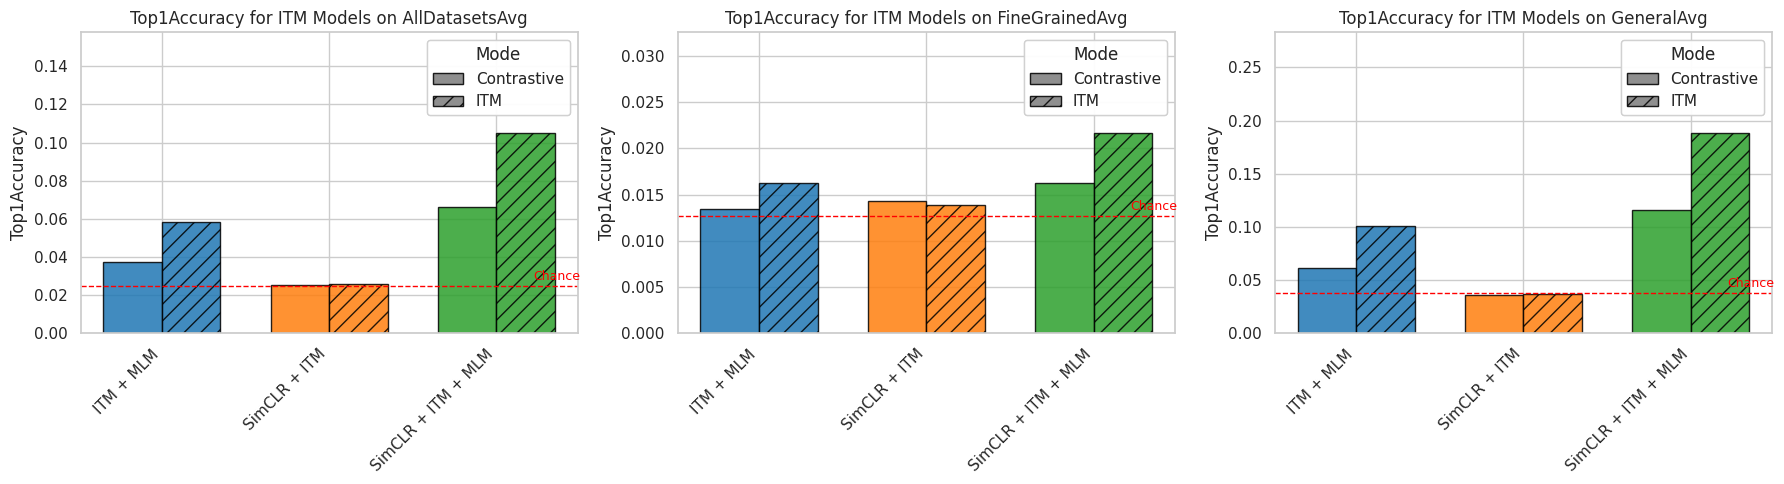

In [115]:
def plot_itm_vs_regular_accuracy(
    df,
    dataset_fraction,
    metric,
    template_num,
    require_clip=None,  # None: all, True: only CLIP, False: exclude CLIP
    which_datasets="all",    # "all", "average", or "actual"
    avg_names=("AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"),
    random_chance_dict=None, # dict: dataset -> chance value (0-1)
    color_palette='tab10',  # matplotlib/seaborn palette
    bar_hatch='//',         # hatch pattern for ITM bars
    bar_alpha=0.85,         # transparency for bars
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from matplotlib.patches import Patch

    # Filter for ITM models and Top1Accuracy
    df = df[df['model_name'].str.contains('ITM', na=False)]
    df = df[df['dataset_fraction'] == dataset_fraction]
    df = df[df['metric'] == metric]
    df = df[df['method_notes'] == template_num]
    df = df[df['mode'].isin(['regular', 'itm'])]

    # Filter for CLIP models if requested
    if require_clip is True:
        df = df[df['model_name'].str.contains('CLIP', case=False, na=False)]
    elif require_clip is False:
        df = df[~df['model_name'].str.contains('CLIP', case=False, na=False)]

    # Use model_name if available, else model_id
    if 'model_name' in df.columns and df['model_name'].notna().any():
        df['model_label'] = df['model_name'].fillna(df['model_id'])
    else:
        df['model_label'] = df['model_id']

    # --- Filter datasets based on which_datasets ---
    all_datasets = sorted(df['dataset'].unique())
    if which_datasets == "average":
        datasets = [d for d in all_datasets if d in avg_names]
    elif which_datasets == "actual":
        datasets = [d for d in all_datasets if d not in avg_names]
    else:
        datasets = all_datasets

    # Consistent color mapping for models
    model_list = sorted(df['model_label'].unique())
    colors = sns.color_palette(color_palette, n_colors=len(model_list))
    color_map = dict(zip(model_list, colors))

    n = len(datasets)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        ddf = df[df['dataset'] == dataset]
        pivot = ddf.pivot_table(index='model_label', columns='mode', values='score')
        # Ensure both columns exist for consistent plotting
        for col in ['regular', 'itm']:
            if col not in pivot.columns:
                pivot[col] = np.nan
        pivot = pivot[['regular', 'itm']]
        ax = axes[i]

        # Bar plot with color for model, hatch for ITM
        x = np.arange(len(pivot.index))
        width = 0.35
        max_height = 0
        bars_regular = ax.bar(
            x - width/2, pivot['regular'].values, width=width,
            color=[color_map[m] for m in pivot.index], label='regular', alpha=bar_alpha, edgecolor='black', linewidth=1
        )
        bars_itm = ax.bar(
            x + width/2, pivot['itm'].values, width=width,
            color=[color_map[m] for m in pivot.index], label='itm', alpha=bar_alpha,
            hatch=bar_hatch, edgecolor='black', linewidth=1
        )
        # Adjust ylim to max bar height
        all_vals = np.concatenate([pivot['regular'].values, pivot['itm'].values])
        all_vals = all_vals[~np.isnan(all_vals)]
        if len(all_vals) > 0:
            max_height = np.nanmax(all_vals)
            ax.set_ylim(0, min(1.0, max_height * 1.5))
        else:
            ax.set_ylim(0, 1)

        # Add random chance line if provided
        if random_chance_dict is not None and dataset in random_chance_dict:
            chance = random_chance_dict[dataset]
            ax.axhline(chance, color='red', linestyle='--', linewidth=1, label='Chance')
            ax.text(
                len(x) - 0.5,
                chance + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                'Chance',
                color='red',
                ha='right',
                va='bottom',
                fontsize=9
            )

        ax.set_title(f"{metric} for ITM Models on {dataset}")
        ax.set_ylabel(metric)
        # ax.set_xlabel("Model")
        ax.set_xticks(x)
        ax.set_xticklabels(pivot.index, rotation=45, ha='right')

        # Custom legend: one for model color, one for mode (with hatching)
        model_handles = [Patch(facecolor=color_map[m], edgecolor='black', label=m) for m in pivot.index]
        # For mode legend, use facecolor only for regular, and facecolor+hatch for itm
        mode_handles = [
            Patch(facecolor='gray', edgecolor='black', label='Contrastive', alpha=bar_alpha, linewidth=1),
            Patch(facecolor='gray', edgecolor='black', label='ITM', alpha=bar_alpha, hatch=bar_hatch, linewidth=1)
        ]
        legend1 = ax.legend(handles=mode_handles, title='Mode', loc='upper right')
        ax.add_artist(legend1)
        # Uncomment for model legend:
        # ax.legend(handles=model_handles, title='Model', loc='upper right', fontsize=8)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()


# Example usage:
plot_itm_vs_regular_accuracy(
    df_with_avgs,
    dataset_fraction="1-aug",
    metric="Top1Accuracy", 
    template_num="9_templates", 
    which_datasets="average", 
    require_clip=False, 
    random_chance_dict=random_chance_dict
)

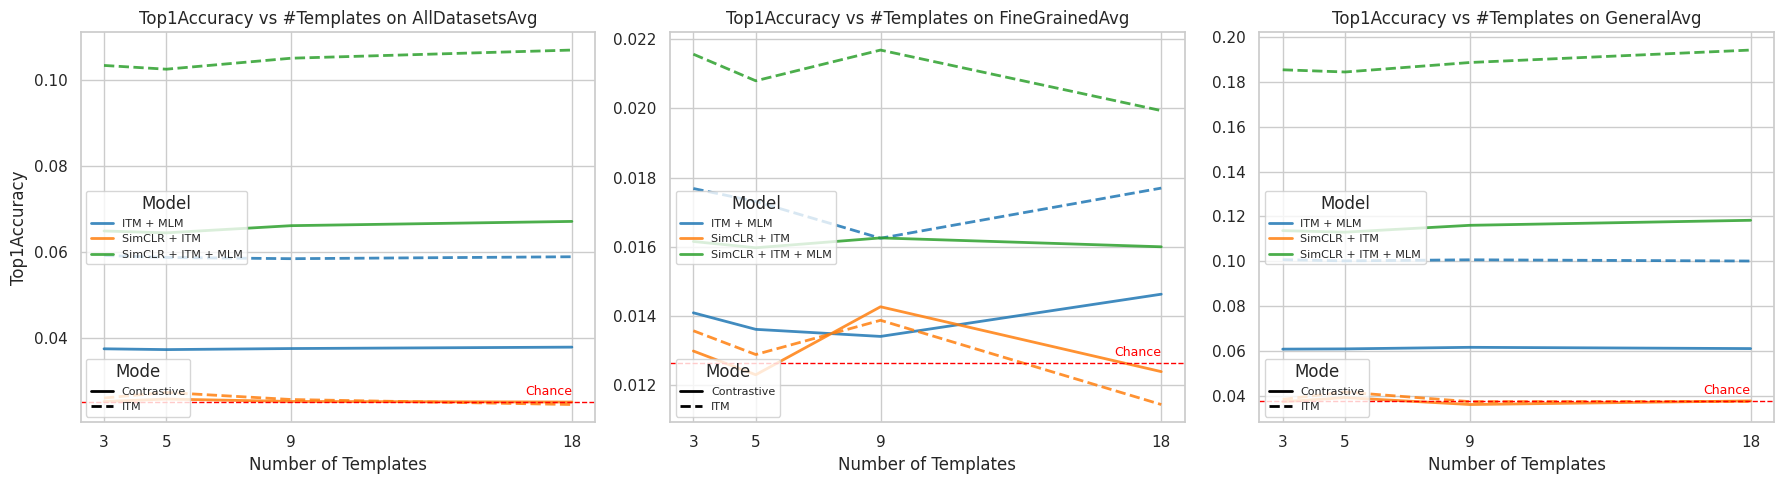

In [116]:
def plot_itm_vs_regular_vs_templates(
    df,
    dataset_fraction,
    metric,
    which_datasets="all",    # "all", "average", or "actual"
    avg_names=("AllDatasetsAvg", "GeneralAvg", "FineGrainedAvg"),
    require_clip=None,       # None: all, True: only CLIP, False: exclude CLIP
    random_chance_dict=None, # dict: dataset -> chance value (0-1)
    color_palette='tab10',   # matplotlib/seaborn palette
    line_alpha=0.85,         # transparency for lines
    line_width=2.0,          # width for lines
):
    """
    Plots accuracy of regular vs ITM when increasing the template amount.
    X axis: template amounts. For every model, two lines (same color, different linestyle) for regular and ITM scores.
    Parameters are similar to plot_itm_vs_regular_accuracy.
    """
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from matplotlib.lines import Line2D

    # Filter for ITM models and Top1Accuracy
    df = df[df['model_name'].str.contains('ITM', na=False)]
    df = df[df['dataset_fraction'] == dataset_fraction]
    df = df[df['metric'] == metric]
    df = df[df['mode'].isin(['regular', 'itm'])]

    # Filter for CLIP models if requested
    if require_clip is True:
        df = df[df['model_name'].str.contains('CLIP', case=False, na=False)]
    elif require_clip is False:
        df = df[~df['model_name'].str.contains('CLIP', case=False, na=False)]

    # Use model_name if available, else model_id
    if 'model_name' in df.columns and df['model_name'].notna().any():
        df['model_label'] = df['model_name'].fillna(df['model_id'])
    else:
        df['model_label'] = df['model_id']

    # Extract template amount as int
    df = df.copy()
    df['template_amount'] = df['method_notes'].str.extract(r'(\d+)').astype(float).astype('Int64')

    # --- Filter datasets based on which_datasets ---
    all_datasets = sorted(df['dataset'].unique())
    if which_datasets == "average":
        datasets = [d for d in all_datasets if d in avg_names]
    elif which_datasets == "actual":
        datasets = [d for d in all_datasets if d not in avg_names]
    else:
        datasets = all_datasets

    # Consistent color mapping for models
    model_list = sorted(df['model_label'].unique())
    colors = sns.color_palette(color_palette, n_colors=len(model_list))
    color_map = dict(zip(model_list, colors))

    n = len(datasets)
    ncols = min(3, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 5 * nrows), squeeze=False)
    axes = axes.flatten()

    for i, dataset in enumerate(datasets):
        ddf = df[df['dataset'] == dataset]
        ax = axes[i]
        template_amounts = sorted(ddf['template_amount'].dropna().unique())
        # Store handles for legend
        model_handles = []
        model_labels = []
        for model in model_list:
            for mode, linestyle in zip(['regular', 'itm'], ['-', '--']):
                sub = ddf[(ddf['model_label'] == model) & (ddf['mode'] == mode)]
                if sub.empty:
                    continue
                # Ensure all template amounts are present (may be missing for some models)
                y = []
                for t in template_amounts:
                    val = sub[sub['template_amount'] == t]['score']
                    y.append(val.values[0] if not val.empty else np.nan)
                # Only add model handle for 'regular' once
                if mode == 'regular':
                    line, = ax.plot(
                        template_amounts, y,
                        label=model,
                        color=color_map[model],
                        linestyle=linestyle,
                        alpha=line_alpha,
                        linewidth=line_width,
                    )
                    model_handles.append(line)
                    model_labels.append(model)
                else:
                    ax.plot(
                        template_amounts, y,
                        color=color_map[model],
                        linestyle=linestyle,
                        alpha=line_alpha,
                        linewidth=line_width,
                    )
        # Add random chance line if provided
        if random_chance_dict is not None and dataset in random_chance_dict:
            chance = random_chance_dict[dataset]
            ax.axhline(chance, color='red', linestyle='--', linewidth=1, label='Chance')
            ax.text(
                template_amounts[-1] if template_amounts else 0,
                chance + 0.01 * (ax.get_ylim()[1] - ax.get_ylim()[0]),
                'Chance',
                color='red',
                ha='right',
                va='bottom',
                fontsize=9
            )
        ax.set_title(f"{metric} vs #Templates on {dataset}")
        ax.set_xlabel("Number of Templates")
        # Only set ylabel for the leftmost column
        if i % ncols == 0:
            ax.set_ylabel(metric)
        ax.set_xticks(template_amounts)
        ax.set_xticklabels([str(int(t)) for t in template_amounts])
        ax.grid(True)
        # Add legend: models and line styles
        handles = model_handles
        labels = model_labels
        # Add line style legend for regular/itm
        style_handles = [
            Line2D([0], [0], color='black', linestyle='-', linewidth=2, label='Contrastive'),
            Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='ITM'),
        ]
        legend1 = ax.legend(handles=handles, labels=labels, title="Model", loc='center left', fontsize=8)
        ax.add_artist(legend1)
        ax.legend(handles=style_handles, title="Mode", loc='lower left', fontsize=8)

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()


plot_itm_vs_regular_vs_templates(
    df_with_avgs,
    dataset_fraction="1-aug",
    metric="Top1Accuracy",  
    which_datasets="average", 
    require_clip=False, 
    random_chance_dict=random_chance_dict
)

In [37]:
def print_itm_vs_regular_table(csv_path, method_notes="9_templates"):
    import pandas as pd

    df = pd.read_csv(csv_path)
    # Filter for ITM models and Top1Accuracy
    df = df[df['model_name'].str.contains('ITM', na=False)]
    df = df[df['metric'] == 'Top1Accuracy']
    df = df[df['mode'].isin(['regular', 'itm'])]
    # Filter for specific method notes if provided
    if method_notes is not None:
        df = df[df['method_notes'] == method_notes]

    # Use model_name if available, else model_id
    if 'model_name' in df.columns and df['model_name'].notna().any():
        df['model_label'] = df['model_name'].fillna(df['model_id'])
    else:
        df['model_label'] = df['model_id']

    # Pivot table: rows=datasets, columns=(model, mode)
    table = df.pivot_table(
        index='dataset',
        columns=['model_label', 'mode'],
        values='score',
        aggfunc='first'
    )

    # Sort columns for consistent order
    table = table.sort_index(axis=1, level=[0,1])

    # Print as percent with 2 decimals
    # print(table.applymap(lambda x: f"{x*100:.2f}" if pd.notnull(x) else "-"))
    table = table.applymap(lambda x: f"{x*100:.2f}" if pd.notnull(x) else "-")
    return table

# Example usage:
print_itm_vs_regular_table(csv_path)

model_label   CLIP + ITM         CLIP + ITM + MLM          \
mode                 itm regular              itm regular   
dataset                                                     
CIFAR10            45.94   49.96            57.72   59.02   
CIFAR100           18.86   19.87            22.00   22.70   
Caltech101         39.26   40.57            46.20   46.38   
Caltech256         32.49   33.94            38.07   39.13   
DTD                18.24   18.70            14.68   15.45   
FGVCAircraft        1.17    1.18             0.84    0.85   
Food101            13.50   14.11            13.10   13.63   
ImageNet           13.19   14.05            14.37   15.02   
OxfordIIITPet       8.75    9.71             9.05    9.32   
Places365          17.48   18.04            19.06   19.83   
STL10              77.96   79.93            79.78   80.48   
StanfordCars        0.82    0.82             0.77    0.74   

model_label   CLIP + ITM + SimCLR + MLM         CLIP + SimCLR + ITM          \
mode                                itm regular                 itm regular   
dataset                                                                       
CIFAR10                           50.74   53.70               45.11   46.17   
CIFAR100                          18.47   19.99               13.10   13.57   
Caltech101                        39.65   40.41               35.21   38.89   
Caltech256                        32.53   33.81               27.42   29.36   
DTD                               17.71   18.70               15.32   15.98   
FGVCAircraft                       1.05    1.05                1.35    1.38   
Food101                           13.06   13.97               11.63   12.71   
ImageNet                          12.63   13.23               11.71   12.69   
OxfordIIITPet                      8.83    9.35                7.83    9.06   
Places365                         17.67   18.46               15.27   16.03   
STL10                             78.88   79.56               72.82   74.36   
StanfordCars                       0.88    0.92                0.79    0.81   

model_label   ITM + MLM         SimCLR + ITM         SimCLR + ITM + MLM  \
mode                itm regular          itm regular                itm   
dataset                                                                   
CIFAR10           14.88   11.70         9.98    9.78              40.89   
CIFAR100           1.81    1.37         1.02    0.95               3.63   
Caltech101         1.73    0.94         0.61    0.52               5.85   
Caltech256         0.60    0.34         0.31    0.34               1.98   
DTD                3.46    2.85         2.77    3.01               4.26   
FGVCAircraft       1.05    0.78         1.05    1.05               1.20   
Food101            1.64    1.27         0.94    0.98               1.49   
ImageNet           0.13    0.10         0.10    0.11               0.34   
OxfordIIITPet      2.34    2.15         2.80    2.72               4.46   
Places365          0.72    0.50         0.38    0.32               1.13   
STL10             41.22   22.48        10.36    9.90              60.52   
StanfordCars       0.54    0.50         0.39    0.49               0.48   

model_label            
mode          regular  
dataset                
CIFAR10         26.99  
CIFAR100         2.20  
Caltech101       3.19  
Caltech256       1.19  
DTD              2.87  
FGVCAircraft     1.06  
Food101          1.10  
ImageNet         0.20  
OxfordIIITPet    3.57  
Places365        0.67  
STL10           35.83  
StanfordCars     0.47

## Accuracy vs. #training examples

In [9]:
def plot_zeroshot_accuracy_vs_fraction(
    csv_path,
    dataset,
    metric='Top1Accuracy',
    method_notes='1_templates',
    model_names=None,
    require_clip=False,
    random_chance_dict=None,
    ylim=(0, 1),
    legend_loc='best',
    fraction_min=0.05,
    fraction_max=1.0
):
    """
    Plots zero-shot accuracy for each model on a given dataset as the training dataset fraction increases.

    Args:
        csv_path (str): Path to the CSV file.
        dataset (str): Dataset name to plot.
        metric (str): Metric to plot (default: 'Top1Accuracy').
        method_notes (str): Method notes to filter (default: '1_templates').
        model_names (list or None): List of model names to include (default: all).
        require_clip (bool): If True, only include models with 'CLIP' in their name.
        random_chance_dict (dict or None): If provided, adds a horizontal line for chance.
        ylim (tuple): y-axis limits.
        legend_loc (str): Location of the legend.
        fraction_min (float): Minimum dataset fraction to include (default: 0.05).
        fraction_max (float): Maximum dataset fraction to include (default: 1.0).
    """
    df = pd.read_csv(csv_path)
    # Filter for the right metric, dataset, and method_notes
    df = df[
        (df['dataset'] == dataset) &
        (df['metric'] == metric) &
        (df['method_notes'] == method_notes)
    ]
    if require_clip:
        df = df[df['model_name'].str.contains('CLIP', case=False, na=False)]
    if model_names is not None:
        df = df[df['model_name'].isin(model_names)]
    # Only keep fractions in the specified range, ignoring non-numeric values
    def is_valid_fraction(x):
        try:
            val = float(x)
            return fraction_min <= val <= fraction_max
        except Exception:
            return False
    df = df[df['dataset_fraction'].apply(is_valid_fraction)]
    # Sort fractions numerically
    df['dataset_fraction'] = df['dataset_fraction'].astype(float)
    fractions = sorted(df['dataset_fraction'].unique())

    plt.figure(figsize=(8, 5))
    for model in df['model_name'].unique():
        model_df = df[df['model_name'] == model].sort_values('dataset_fraction')
        plt.plot(
            model_df['dataset_fraction'],
            model_df['score'],
            marker='o',
            label=model
        )
    if random_chance_dict and dataset in random_chance_dict:
        plt.axhline(random_chance_dict[dataset], color='red', linestyle='--', label='Chance')
    plt.xlabel('Training Dataset Fraction')
    plt.ylabel(metric)
    plt.title(f'Zero-Shot {metric} vs. Training Dataset Fraction on {dataset}')
    # plt.ylim(ylim)
    plt.xticks(fractions, [str(f) for f in fractions])
    plt.legend(loc=legend_loc)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

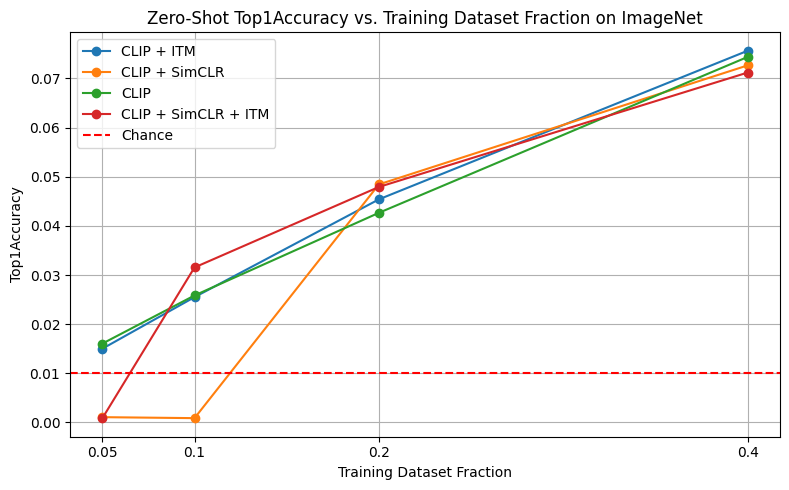

In [10]:
plot_zeroshot_accuracy_vs_fraction(
    csv_path=csv_path,
    dataset="ImageNet",
    metric="Top1Accuracy",
    method_notes="1_templates",
    random_chance_dict=random_chance_dict,
    require_clip=True,
    fraction_min=0.05,
    fraction_max=0.4
)

In [13]:
def plot_zeroshot_accuracy_vs_fraction_all(
    csv_path,
    metric='Top1Accuracy',
    method_notes='1_templates',
    model_names=None,
    require_clip=False,
    random_chance_dict=None,
    ylim=(0, 1),
    legend_loc='best',
    fraction_min=0.05,
    fraction_max=1.0,
    general_datasets=None,
    finegrained_datasets=None,
    ncols=3
):
    """
    Plots zero-shot accuracy vs. training dataset fraction for all datasets and for average performance
    on all, general, and fine-grained datasets.

    Args:
        csv_path (str): Path to the CSV file.
        metric (str): Metric to plot (default: 'Top1Accuracy').
        method_notes (str): Method notes to filter (default: '1_templates').
        model_names (list or None): List of model names to include (default: all).
        require_clip (bool): If True, only include models with 'CLIP' in their name.
        random_chance_dict (dict or None): If provided, adds a horizontal line for chance.
        ylim (tuple): y-axis limits.
        legend_loc (str): Location of the legend.
        fraction_min (float): Minimum dataset fraction to include (default: 0.05).
        fraction_max (float): Maximum dataset fraction to include (default: 1.0).
        general_datasets (list or None): List of general dataset names.
        finegrained_datasets (list or None): List of fine-grained dataset names.
        ncols (int): Number of columns in subplot grid.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

    df = pd.read_csv(csv_path)
    df = df[
        (df['metric'] == metric) &
        (df['method_notes'] == method_notes)
    ]
    if require_clip:
        df = df[df['model_name'].str.contains('CLIP', case=False, na=False)]
    if model_names is not None:
        df = df[df['model_name'].isin(model_names)]

    # Only keep fractions in the specified range, ignoring non-numeric values
    def is_valid_fraction(x):
        try:
            val = float(x)
            return fraction_min <= val <= fraction_max
        except Exception:
            return False
    df = df[df['dataset_fraction'].apply(is_valid_fraction)]
    df['dataset_fraction'] = df['dataset_fraction'].astype(float)
    fractions = sorted(df['dataset_fraction'].unique())

    # Get all datasets to plot
    datasets = sorted(df['dataset'].unique())

    # Prepare average datasets
    if general_datasets is None:
        general_datasets = ["ImageNet", "Caltech101", "Caltech256", "CIFAR10", "CIFAR100", "STL10"]
    if finegrained_datasets is None:
        finegrained_datasets = ["Places365", "OxfordIIITPet", "Food101", "DTD", "StanfordCars", "FGVCAircraft"]

    avg_types = [
        ("Average: All", datasets),
        ("Average: General", general_datasets),
        ("Average: Fine-Grained", finegrained_datasets),
    ]

    n_plots = len(datasets) + len(avg_types)
    nrows = int(np.ceil(n_plots / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(6 * ncols, 4 * nrows), squeeze=False)
    axes = axes.flatten()

    # Plot for each dataset
    for i, dataset in enumerate(datasets):
        ax = axes[i]
        for model in df['model_name'].unique():
            model_df = df[(df['model_name'] == model) & (df['dataset'] == dataset)].sort_values('dataset_fraction')
            ax.plot(
                model_df['dataset_fraction'],
                model_df['score'],
                marker='o',
                label=model
            )
        # Add random chance line if available
        if random_chance_dict and dataset in random_chance_dict:
            ax.axhline(random_chance_dict[dataset], color='red', linestyle='--', label='Chance')
        ax.set_xlabel('Training Dataset Fraction')
        ax.set_ylabel(metric)
        ax.set_title(dataset)
        # ax.set_ylim(ylim)
        ax.set_xticks(fractions)
        ax.set_xticklabels([str(f) for f in fractions])
        ax.grid(True)
        ax.legend(loc=legend_loc)

    # Plot averages
    for j, (avg_name, avg_datasets) in enumerate(avg_types):
        ax = axes[len(datasets) + j]
        for model in df['model_name'].unique():
            avg_scores = []
            for frac in fractions:
                vals = df[
                    (df['model_name'] == model) &
                    (df['dataset'].isin(avg_datasets)) &
                    (df['dataset_fraction'] == frac)
                ]['score']
                avg_scores.append(vals.mean() if not vals.empty else np.nan)
            ax.plot(
                fractions,
                avg_scores,
                marker='o',
                label=model
            )
        # Add average random chance line if available
        if random_chance_dict:
            chances = [random_chance_dict[d] for d in avg_datasets if d in random_chance_dict]
            if chances:
                avg_chance = np.mean(chances)
                ax.axhline(avg_chance, color='red', linestyle='--', label='Chance')
        ax.set_xlabel('Training Dataset Fraction')
        ax.set_ylabel(metric)
        ax.set_title(avg_name)
        # ax.set_ylim(ylim)
        ax.set_xticks(fractions)
        ax.set_xticklabels([str(f) for f in fractions])
        ax.grid(True)
        ax.legend(loc=legend_loc)

    # Hide unused axes
    for k in range(n_plots, len(axes)):
        fig.delaxes(axes[k])

    plt.tight_layout()
    plt.show()

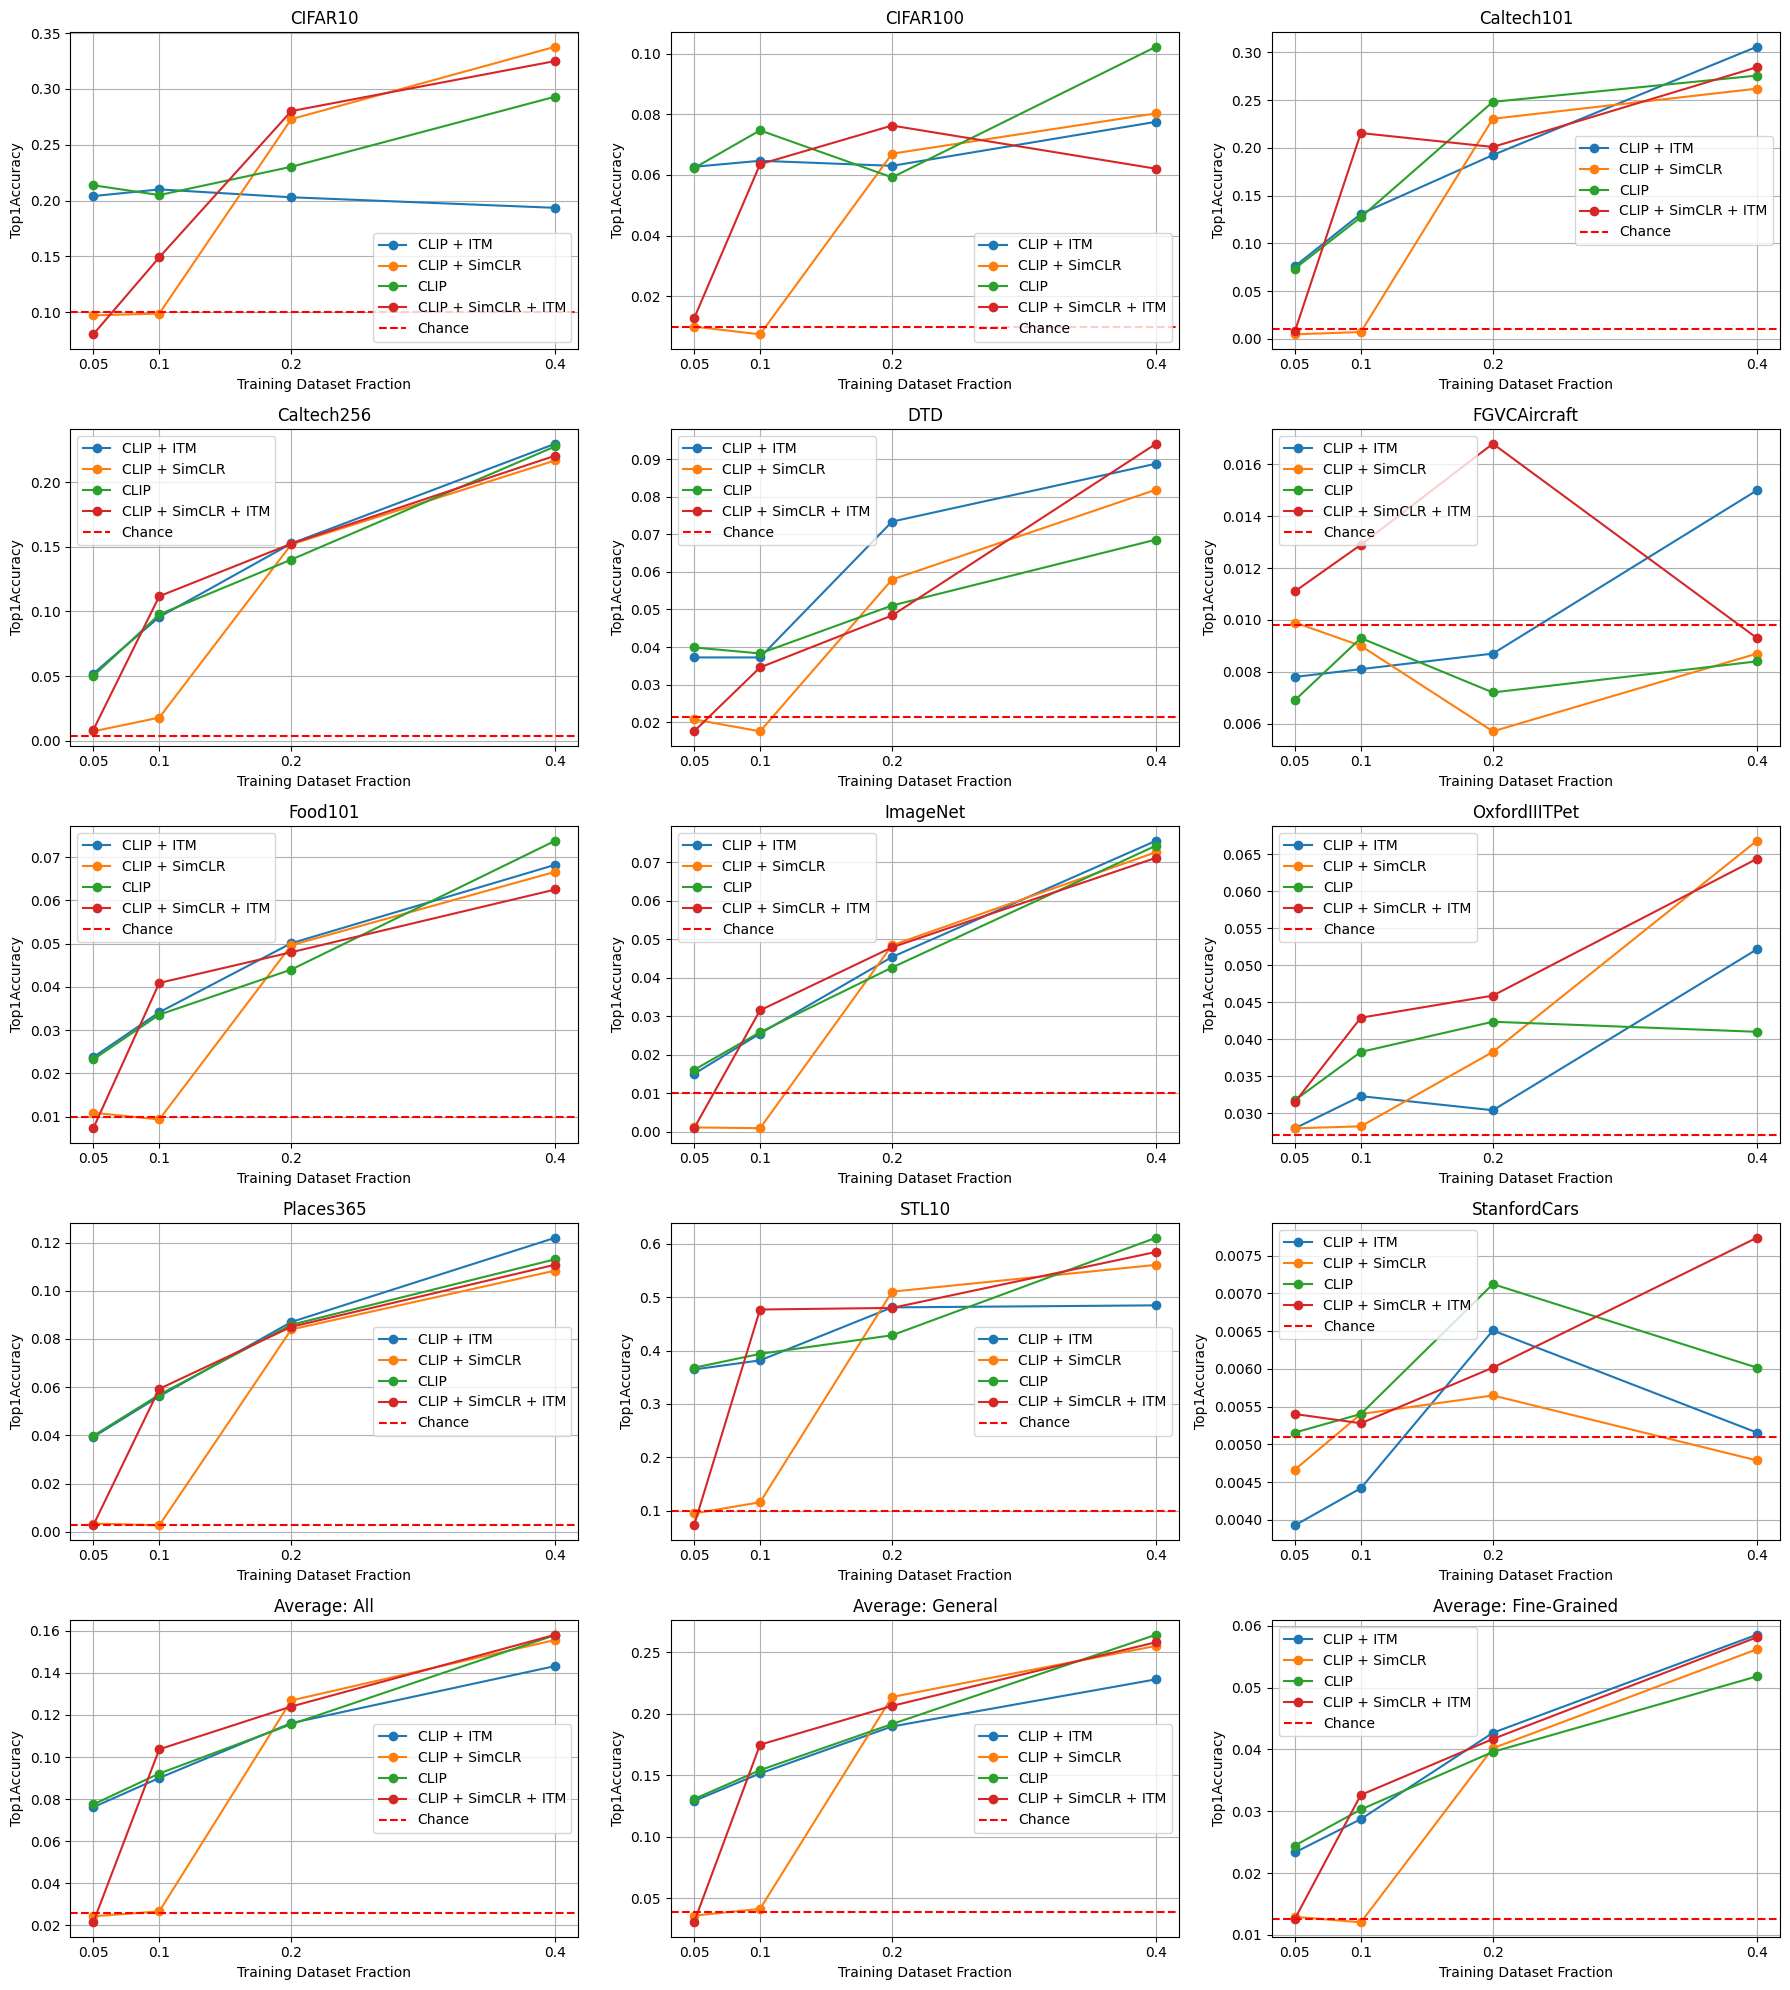

In [15]:
plot_zeroshot_accuracy_vs_fraction_all(
    csv_path=csv_path,
    metric="Top1Accuracy",
    method_notes="1_templates",
    random_chance_dict=random_chance_dict,
    require_clip=True,
    fraction_min=0.05,
    fraction_max=0.4
)

# Image-text retrieval

In [1]:
csv_path = "../../test_results/model_scores_retrieval.csv"
model_order = [
    "CLIP",
    "CLIP + ITM",
    "CLIP + SimCLR",
    "CLIP + MLM",
    "CLIP + SimCLR + ITM",
    "CLIP + ITM + MLM",
    "CLIP + SimCLR + MLM",
    "CLIP + ITM + SimCLR + MLM",
    "SimCLR",
    "SimCLR + MLM",
    "SimCLR + ITM",
    "SimCLR + ITM + MLM",
    "ITM + MLM",
]

## Table

In [2]:
import pandas as pd

def make_retrieval_table(
    csv_path,
    recall_k=1,
    image_retrieval=True,
    text_retrieval=True,
    model_col="model",
    dataset_col="dataset",
    dataset_fraction=None  # e.g., "1-aug", "0.1", etc.
):
    """
    Create a table of retrieval scores from a CSV file.
    Rows: models
    Columns: datasets, with subcolumns for image/text retrieval (recall@k)
    Adds a column for the average over all datasets (per retrieval type).
    Optionally filter by dataset fraction, which is at the end of the model name after "_".
    """
    df = pd.read_csv(csv_path)

    # If filtering by dataset_fraction, extract it from model name
    if dataset_fraction is not None:
        # Extract fraction after last "_" in model name
        df = df.copy()
        df["dataset_fraction"] = df[model_col].str.extract(r"_([^_]+)$")[0]
        # print(df["dataset_fraction"])
        df = df[df["dataset_fraction"] == dataset_fraction]
    
    # Remove suffix from "_" onwards in model_col values
    df[model_col] = df[model_col].str.split("_").str[0]

    # Determine which columns to use
    cols = []
    col_map = {}
    if image_retrieval:
        col = f"image_retrieval_recall@{recall_k}"
        cols.append(col)
        col_map[col] = "Image Retrieval"
    if text_retrieval:
        col = f"text_retrieval_recall@{recall_k}"
        cols.append(col)
        col_map[col] = "Text Retrieval"

    # Filter to only needed columns
    keep_cols = [model_col, dataset_col] + cols
    df = df[keep_cols]

    # Pivot to MultiIndex columns: (dataset, retrieval_type)
    data = []
    for retrieval_col in cols:
        retrieval_type = col_map[retrieval_col]
        pivot = df.pivot_table(index=model_col, columns=dataset_col, values=retrieval_col)
        # Add retrieval type as a new level in columns
        pivot.columns = pd.MultiIndex.from_product([pivot.columns, [retrieval_type]])
        data.append(pivot)
    table = pd.concat(data, axis=1)
    # Sort columns for readability
    table = table.sort_index(axis=1, level=[0,1])

    # Add average columns (over datasets, per retrieval type)
    for retrieval_col in cols:
        retrieval_type = col_map[retrieval_col]
        cols_for_type = [col for col in table.columns if col[1] == retrieval_type]
        table[("Average", retrieval_type)] = table[cols_for_type].mean(axis=1)

    # # Sort columns again to put Average at the end
    # table = table.reindex(
    #     columns=sorted([c for c in table.columns if c[0] != "Average"], key=lambda x: (x[0], x[1])) +
    #             [c for c in table.columns if c[0] == "Average"],
    #     level=0
    # )

    return table

# Example usage:
# table = make_retrieval_table("test_results/model_scores_retrieval.csv", recall_k=5, dataset_fraction="1-aug")
# display(table.style.format("{:.3f}"))

In [3]:
table = make_retrieval_table(csv_path, recall_k=1, dataset_fraction="1-aug")
display(table.style.format(lambda x: f"{x * 100:.2f}"))

In [19]:
def make_single_retrieval_table(
    table,
    retrieval_type="Image Retrieval",  # "Image Retrieval" or "Text Retrieval"
    sort_descending=False,             # sort models by a dataset column
    sort_by=None                       # dataset name to sort by (e.g. "Average" or a dataset)
):
    """
    Returns a table (DataFrame) with only the values for the specified retrieval type.
    Rows: models, Columns: datasets (including 'Average').
    Optionally sorts the rows (models) by a specific dataset column in descending order.
    Adds a column header to indicate values are recall@k scores.

    Args:
        table (pd.DataFrame): MultiIndex columns (dataset, retrieval_type), index=model names.
        retrieval_type (str): "Image Retrieval" or "Text Retrieval".
        sort_descending (bool): If True, sort models by the values in sort_by column.
        sort_by (str or None): Dataset column to sort by (e.g. "Average" or a dataset name).

    Returns:
        pd.DataFrame: DataFrame with models as rows and datasets as columns for the given retrieval type.
    """
    # Select columns for the given retrieval type
    cols = [col for col in table.columns if col[1] == retrieval_type]
    single_table = table[cols].copy()
    # Flatten columns: keep only dataset name, but add a second level for the header
    single_table.columns = pd.MultiIndex.from_tuples(
        [(col[0], "recall@k") for col in single_table.columns],
        names=["Dataset", "Metric"]
    )
    # Optionally, move 'Average' to the end
    cols_order = [c for c in single_table.columns if c[0] != "Average"] + ([c for c in single_table.columns if c[0] == "Average"])
    single_table = single_table[cols_order]
    # Optionally sort models by a specific dataset column
    if sort_descending and sort_by is not None and (sort_by, "recall@k") in single_table.columns:
        single_table = single_table.sort_values(by=(sort_by, "recall@k"), ascending=False)
    return single_table

# Example usage:
# image_table = make_single_retrieval_table(table, retrieval_type="Image Retrieval", sort_descending=True, sort_by="Average")
# display(image_table.style.format("{:.2f}"))

In [20]:
image_table = make_single_retrieval_table(table, sort_descending=True, sort_by="Average", retrieval_type="Image Retrieval")
display(image_table.style.format(lambda x: f"{x * 100:.2f}"))

In [18]:
text_table = make_single_retrieval_table(table, sort_descending=True, sort_by="Average", retrieval_type="Text Retrieval")
display(text_table.style.format(lambda x: f"{x * 100:.2f}"))

## Bar chart

In [7]:
def plot_retrieval_barcharts(
    table,
    figsize=(18, 7),
    bar_width=0.35,
    fontsize=10,
    require_clip=None  # None: no filter, True: only CLIP, False: exclude CLIP
):
    """
    Plots bar charts for every dataset (including average score) from the retrieval table.
    Each subplot is a dataset, x-axis is models, two bars per model (image and text retrieval).
    The average chart is shown first.

    Args:
        table (pd.DataFrame): MultiIndex columns (dataset, retrieval_type), index=model names.
        require_clip (bool or None): If True, only models with 'CLIP' in name. If False, exclude those. If None, no filter.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter models if required
    models = table.index.tolist()
    if require_clip is True:
        models = [m for m in models if "CLIP" in m]
    elif require_clip is False:
        models = [m for m in models if "CLIP" not in m]
    filtered_table = table.loc[models]

    # Get all datasets and retrieval types
    datasets = sorted(set([col[0] for col in filtered_table.columns if col[0] != "Average"]))
    retrieval_types = [col for col in filtered_table.columns.levels[1]]
    all_datasets = ["Average"] + datasets

    n_datasets = len(all_datasets)
    ncols = min(4, n_datasets)
    nrows = int(np.ceil(n_datasets / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows), squeeze=False)
    axes = axes.flatten()

    x = np.arange(len(models))

    for i, dataset in enumerate(all_datasets):
        ax = axes[i]
        bars = []
        labels = []
        max_y = 0
        for j, retrieval in enumerate(retrieval_types):
            col = (dataset, retrieval)
            if col not in filtered_table.columns:
                continue
            y = filtered_table[col].values * 100 if filtered_table[col].max() <= 1.0 else filtered_table[col].values
            offset = (j - 0.5) * bar_width
            bar = ax.bar(x + offset, y, width=bar_width, label=retrieval)
            bars.append(bar)
            labels.append(retrieval)
            if len(y) > 0 and np.nanmax(y) > max_y:
                max_y = np.nanmax(y)
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=90, ha='right', fontsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize+2)
        ax.set_ylabel("Recall@k (%)", fontsize=fontsize)
        ax.legend(fontsize=fontsize)
        # ax.grid(axis='y', linestyle='--', alpha=0.9, zorder=0, which='both')
        if max_y > 0:
            upper = min(100, max_y * 1.08)
            ax.set_ylim(0, upper)
        else:
            ax.set_ylim(0, 100)
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle("Retrieval Recall@k for Each Dataset (Image/Text)", fontsize=fontsize+4)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

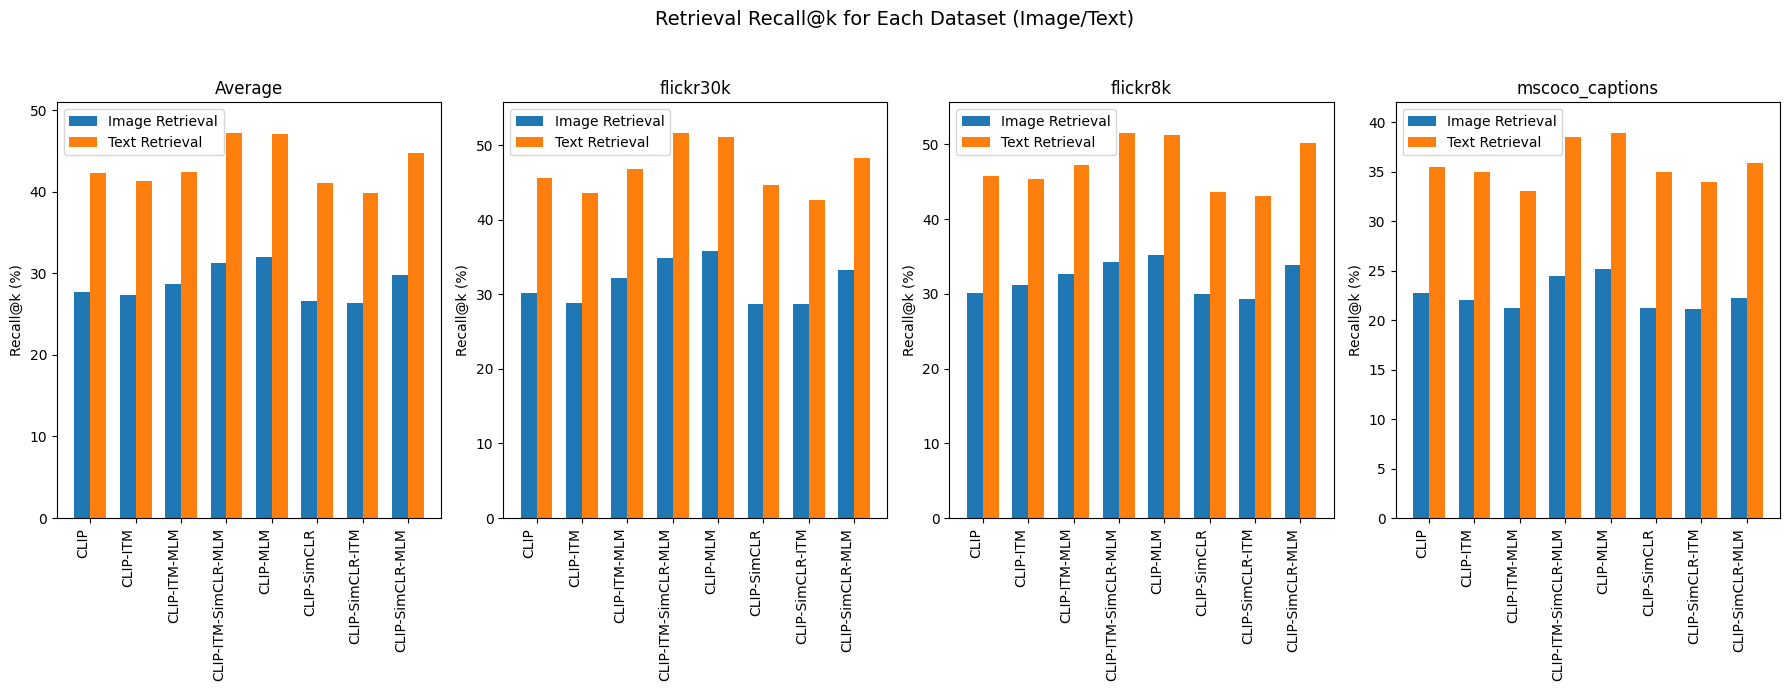

In [8]:
plot_retrieval_barcharts(table, require_clip=True)

In [12]:
def plot_single_retrieval_barcharts(
    table,
    retrieval_type="Image Retrieval",  # "Image Retrieval" or "Text Retrieval"
    figsize=(18, 5),
    bar_width=0.5,
    fontsize=10,
    require_clip=None,  # None: no filter, True: only CLIP, False: exclude CLIP
    sort_bars=False,    # NEW: plot bars in descending order
    palette='tab10'     # NEW: color code models consistently
):
    """
    Plots bar charts for every dataset (including average score) from the retrieval table,
    but only for a single retrieval type (image or text).
    Each subplot is a dataset, x-axis is models, one bar per model.
    Bars are color-coded by model and can be sorted by value.

    Args:
        table (pd.DataFrame): MultiIndex columns (dataset, retrieval_type), index=model names.
        retrieval_type (str): "Image Retrieval" or "Text Retrieval".
        require_clip (bool or None): If True, only models with 'CLIP' in name. If False, exclude those. If None, no filter.
        sort_bars (bool): If True, sort bars in descending order per subplot.
        palette (str or list): Matplotlib/seaborn palette or list of colors for models.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Filter models if required
    models = table.index.tolist()
    if require_clip is True:
        models = [m for m in models if "CLIP" in m]
    elif require_clip is False:
        models = [m for m in models if "CLIP" not in m]
    filtered_table = table.loc[models]

    # Get all datasets for this retrieval type
    datasets = sorted(set([col[0] for col in filtered_table.columns if col[0] != "Average" and col[1] == retrieval_type]))
    all_datasets = ["Average"] + datasets

    n_datasets = len(all_datasets)
    ncols = min(4, n_datasets)
    nrows = int(np.ceil(n_datasets / ncols))

    # Consistent color mapping for models
    model_list = list(models)
    colors = sns.color_palette(palette, n_colors=len(model_list))
    color_map = dict(zip(model_list, colors))

    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize[0], figsize[1]*nrows), squeeze=False)
    axes = axes.flatten()

    for i, dataset in enumerate(all_datasets):
        ax = axes[i]
        col = (dataset, retrieval_type)
        if col not in filtered_table.columns:
            ax.set_visible(False)
            continue
        y = filtered_table[col].values * 100 if filtered_table[col].max() <= 1.0 else filtered_table[col].values
        x_labels = list(models)
        bar_colors = [color_map[m] for m in x_labels]
        # Optionally sort bars
        if sort_bars:
            sorted_idx = np.argsort(-y)
            y = y[sorted_idx]
            x_labels = [x_labels[j] for j in sorted_idx]
            bar_colors = [bar_colors[j] for j in sorted_idx]
        x = np.arange(len(x_labels))
        ax.bar(x, y, width=bar_width, color=bar_colors)
        ax.set_xticks(x)
        ax.set_xticklabels(x_labels, rotation=90, ha='right', fontsize=fontsize)
        ax.set_title(dataset, fontsize=fontsize+2)
        ax.set_ylabel("Recall@k (%)", fontsize=fontsize)
        ax.grid(axis='y', linestyle='--', alpha=0.9, zorder=0, which='both')
        # Set y-limit just above the highest bar (add 8% margin, but never above 100)
        if len(y) > 0 and np.nanmax(y) > 0:
            upper = min(100, np.nanmax(y) * 1.08)
            ax.set_ylim(0, upper)
        else:
            ax.set_ylim(0, 100)
        # Only add legend to the first subplot
        if i == 3:
            handles = [plt.Rectangle((0,0),1,1, color=color_map[m]) for m in model_list]
            ax.legend(handles, model_list, title="Model", fontsize=fontsize, bbox_to_anchor=(1.02, 1), loc='upper left')
    # Hide unused axes
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    plt.suptitle(f"Retrieval Recall@k for Each Dataset ({retrieval_type})", fontsize=fontsize+4)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

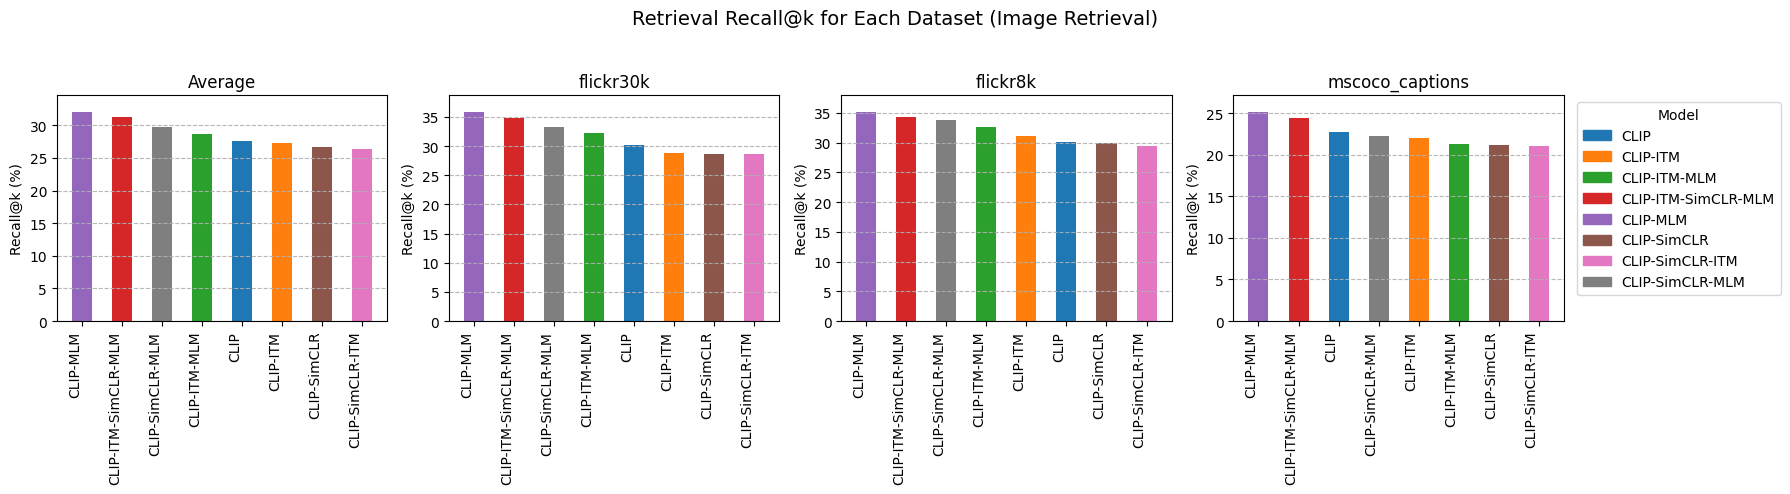

In [14]:
plot_single_retrieval_barcharts(table, require_clip=True, retrieval_type="Image Retrieval", sort_bars=True)

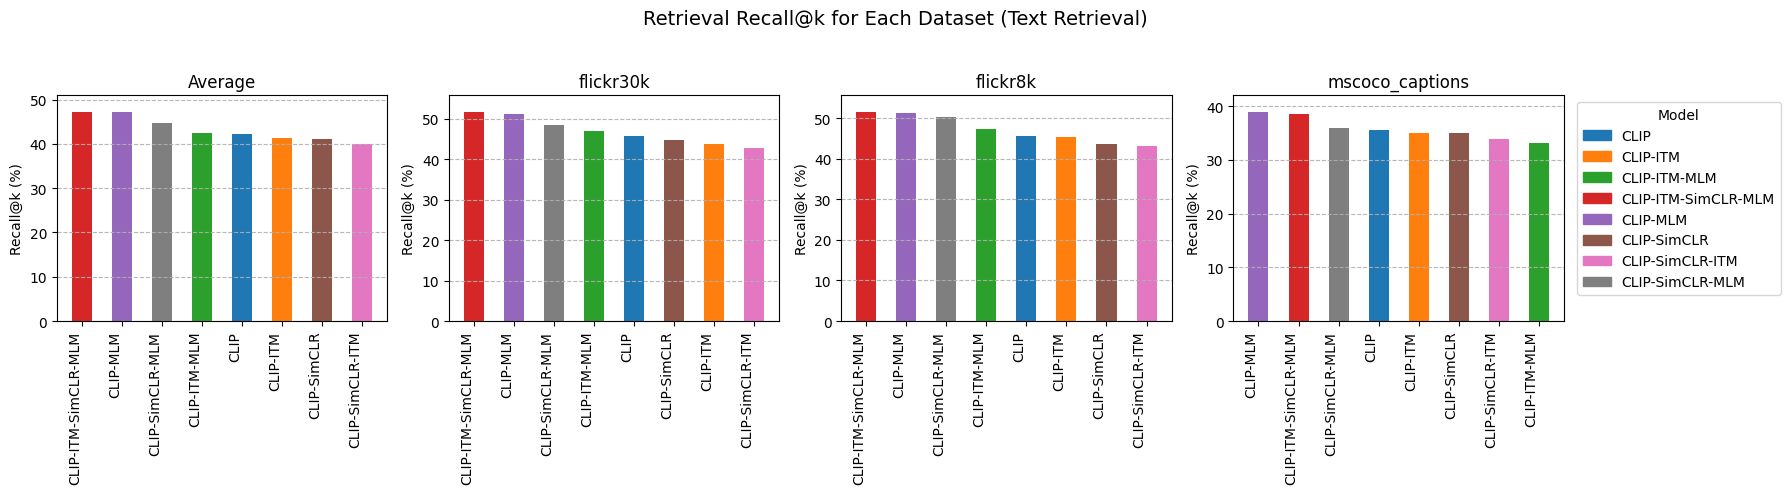

In [13]:
plot_single_retrieval_barcharts(table, require_clip=True, retrieval_type="Text Retrieval", sort_bars=True)

## Delta to CLIP baseline

In [30]:
def plot_retrieval_deltas(
    table,
    retrieval_type="Image Retrieval",  # "Image Retrieval" or "Text Retrieval"
    datasets=None,                     # list of dataset names (must match column level 0)
    figsize=(6, 4),
    show_values=True
):
    """
    Plot delta Recall@k to CLIP baseline for one or more datasets, for a given retrieval type.
    Only models with 'CLIP' in their name are shown. Model names are cleaned: 'CLIP-' → '+', '-' → '+'.

    Parameters:
    - table: DataFrame from make_retrieval_table(), MultiIndex columns (dataset, retrieval_type), index=model names.
    - retrieval_type: "Image Retrieval" or "Text Retrieval".
    - datasets: str or list of dataset names (must match column level 0, e.g. "Average", "Flickr30k", ...).
    - figsize: Size of each subplot.
    - show_values: Show delta values next to bars.
    """
    # Only keep models with 'CLIP' in their name
    models = [m for m in table.index if "CLIP" in m]
    filtered_table = table.loc[models]

    # Select only columns for the given retrieval type
    cols = [col for col in filtered_table.columns if col[1] == retrieval_type]
    df = filtered_table[cols].copy()
    df.columns = [col[0] for col in df.columns]

    # Default: plot all datasets
    if datasets is None:
        datasets = df.columns.tolist()
    if isinstance(datasets, str):
        datasets = [datasets]

    sns.set(style="white")
    num_plots = len(datasets)
    fig, axes = plt.subplots(1, num_plots, figsize=(figsize[0] * num_plots, figsize[1]), sharex=False)
    if num_plots == 1:
        axes = [axes]
    fig.suptitle(f"Delta Recall@k to CLIP baseline ({retrieval_type})", fontsize=16, fontweight='bold')

    for ax, dataset_name in zip(axes, datasets):
        if dataset_name not in df.columns:
            ax.set_visible(False)
            print(f"⚠️ Dataset '{dataset_name}' not found.")
            continue
        row = df[dataset_name]
        if "CLIP" not in row.index:
            ax.set_visible(False)
            print(f"⚠️ CLIP baseline not found for dataset '{dataset_name}'.")
            continue
        baseline = row["CLIP"]
        delta = row.drop("CLIP") - baseline
        delta = delta * 100  # Convert to percentage
        delta = delta.sort_values(ascending=False)
        # Clean model names: 'CLIP-' → '+', '-' → '+', remove spaces
        clean_labels = [
            name.replace("CLIP-", "+").replace("-", "+").replace("CLIP ", "").replace(" ", "")
            for name in delta.index
        ]
        min_val, max_val = delta.min(), delta.max()
        range_padding = (max_val - min_val) * 0.30 if max_val > min_val else 0.1
        x_min = min_val - range_padding
        x_max = max_val + range_padding
        ax.set_xlim(x_min, x_max)
        sns.barplot(x=delta, y=clean_labels, ax=ax, palette="coolwarm", orient='h', hue=clean_labels, legend=False)
        ax.set_title(dataset_name, fontsize=14, fontweight='bold')
        ax.set_xlabel("Δ Recall@k", fontsize=12, fontweight='bold')
        ax.set_ylabel("")
        ax.axvline(0, color='black', linestyle='--', linewidth=1)
        for label in ax.get_yticklabels():
            label.set_fontsize(11)
            label.set_fontweight('bold')
        if show_values:
            for i, val in enumerate(delta.values):
                ha = 'left' if val >= 0 else 'right'
                offset = 0.005 * (x_max - x_min)
                x_pos = val + offset if val >= 0 else val - offset
                ax.text(x_pos, i, f"{val:.3f}", va='center', ha=ha, fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()

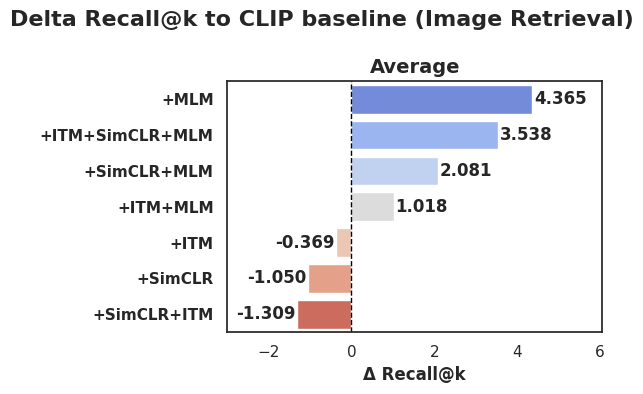

In [31]:
plot_retrieval_deltas(table, retrieval_type="Image Retrieval", datasets=["Average"])

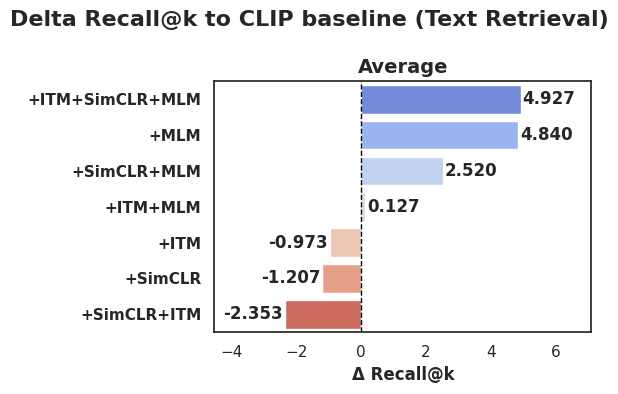

In [32]:
plot_retrieval_deltas(table, retrieval_type="Text Retrieval", datasets=["Average"])

# Linear probing on layers

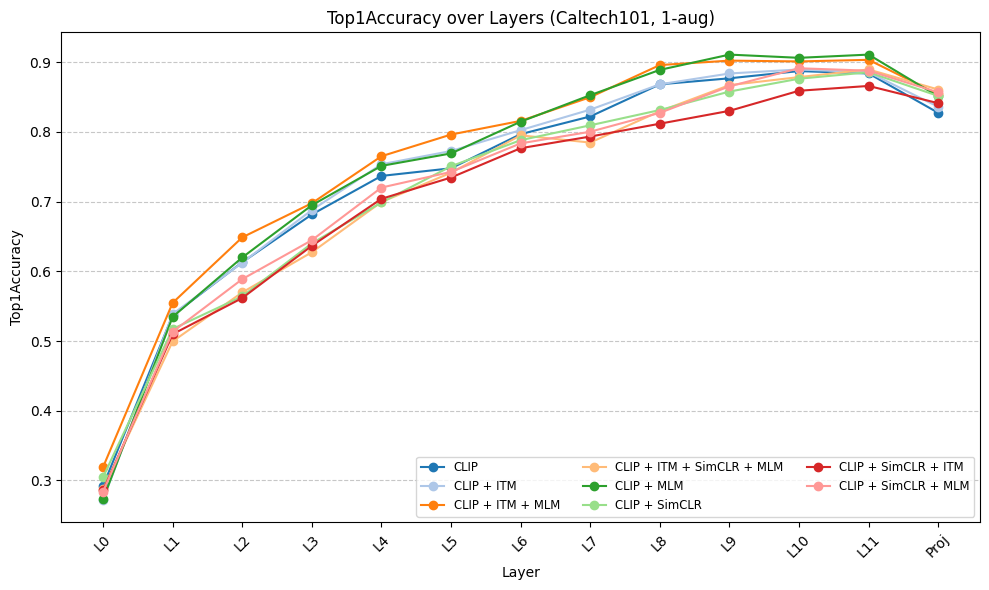

In [16]:
def plot_layerwise_accuracy(
    csv_path,
    dataset="Caltech101",
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    models=None,  # list of model names to include, or None for all
    legend_loc="lower right",
    figsize=(10, 6),
    title=None,
    show_projection=True,
    color_palette="tab20",
    has_clip=None  # NEW: True = only CLIP, False = only non-CLIP, None = all
):
    """
    Plot accuracy over layers for each model.

    Args:
        csv_path (str): Path to the CSV file.
        dataset (str): Dataset to plot (default: "Caltech101").
        metric (str): Accuracy metric to plot (e.g., "Top1Accuracy").
        subset_fraction (str): Subset fraction to filter (e.g., "1-aug").
        models (list or None): List of model names to include. If None, plot all.
        legend_loc (str): Legend location.
        figsize (tuple): Figure size.
        title (str or None): Plot title. If None, generated automatically.
        show_projection (bool): If True, include "projection_layer" as last x-tick.
        color_palette (str or list): Matplotlib/seaborn color palette.
        has_clip (bool or None): If True, only models with 'CLIP' in name; if False, exclude those; if None, all.
    """
    df = pd.read_csv(csv_path)
    # Filter
    df = df[
        (df["dataset"] == dataset) &
        (df["metric"] == metric) &
        (df["subset_fraction"] == subset_fraction)
    ]
    if models is not None:
        df = df[df["model_name"].isin(models)]
    if has_clip is True:
        df = df[df["model_name"].str.contains("CLIP", case=False, na=False)]
    elif has_clip is False:
        df = df[~df["model_name"].str.contains("CLIP", case=False, na=False)]

    # Get all layers in order
    encoder_layers = sorted(
        [l for l in df["layer"].unique() if l.startswith("encoder_layer_")],
        key=lambda x: int(x.split("_")[-1])
    )
    if show_projection and "projection_layer" in df["layer"].unique():
        layers = encoder_layers + ["projection_layer"]
    else:
        layers = encoder_layers

    # Color mapping for models
    model_list = sorted(df["model_name"].unique())
    import seaborn as sns
    colors = sns.color_palette(color_palette, n_colors=len(model_list))
    color_map = dict(zip(model_list, colors))

    plt.figure(figsize=figsize)
    for model in model_list:
        sub = df[df["model_name"] == model]
        y = []
        for l in layers:
            row = sub[sub["layer"] == l]
            y.append(row["score"].values[0] if not row.empty else None)
        plt.plot(
            layers,
            y,
            marker="o",
            label=model,
            color=color_map[model]
        )
    plt.xlabel("Layer")
    plt.ylabel(metric)
    plt.xticks(
        range(len(layers)),
        [l.replace("encoder_layer_", "L") if l != "projection_layer" else "Proj" for l in layers],
        rotation=45
    )
    plt.grid(True, axis="y", linestyle="--", alpha=0.7)
    plt.legend(loc=legend_loc, fontsize='small', ncol=3)
    if title is None:
        title = f"{metric} over Layers ({dataset}, {subset_fraction})"
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_layerwise_accuracy(
    csv_path="../../test_results/linear_probing_layers_results.csv",
    metric="Top1Accuracy",
    subset_fraction="1-aug",
    has_clip=True  # set to True, False, or None as needed
)

# Linear probing visual encoder vs visual projection represenations

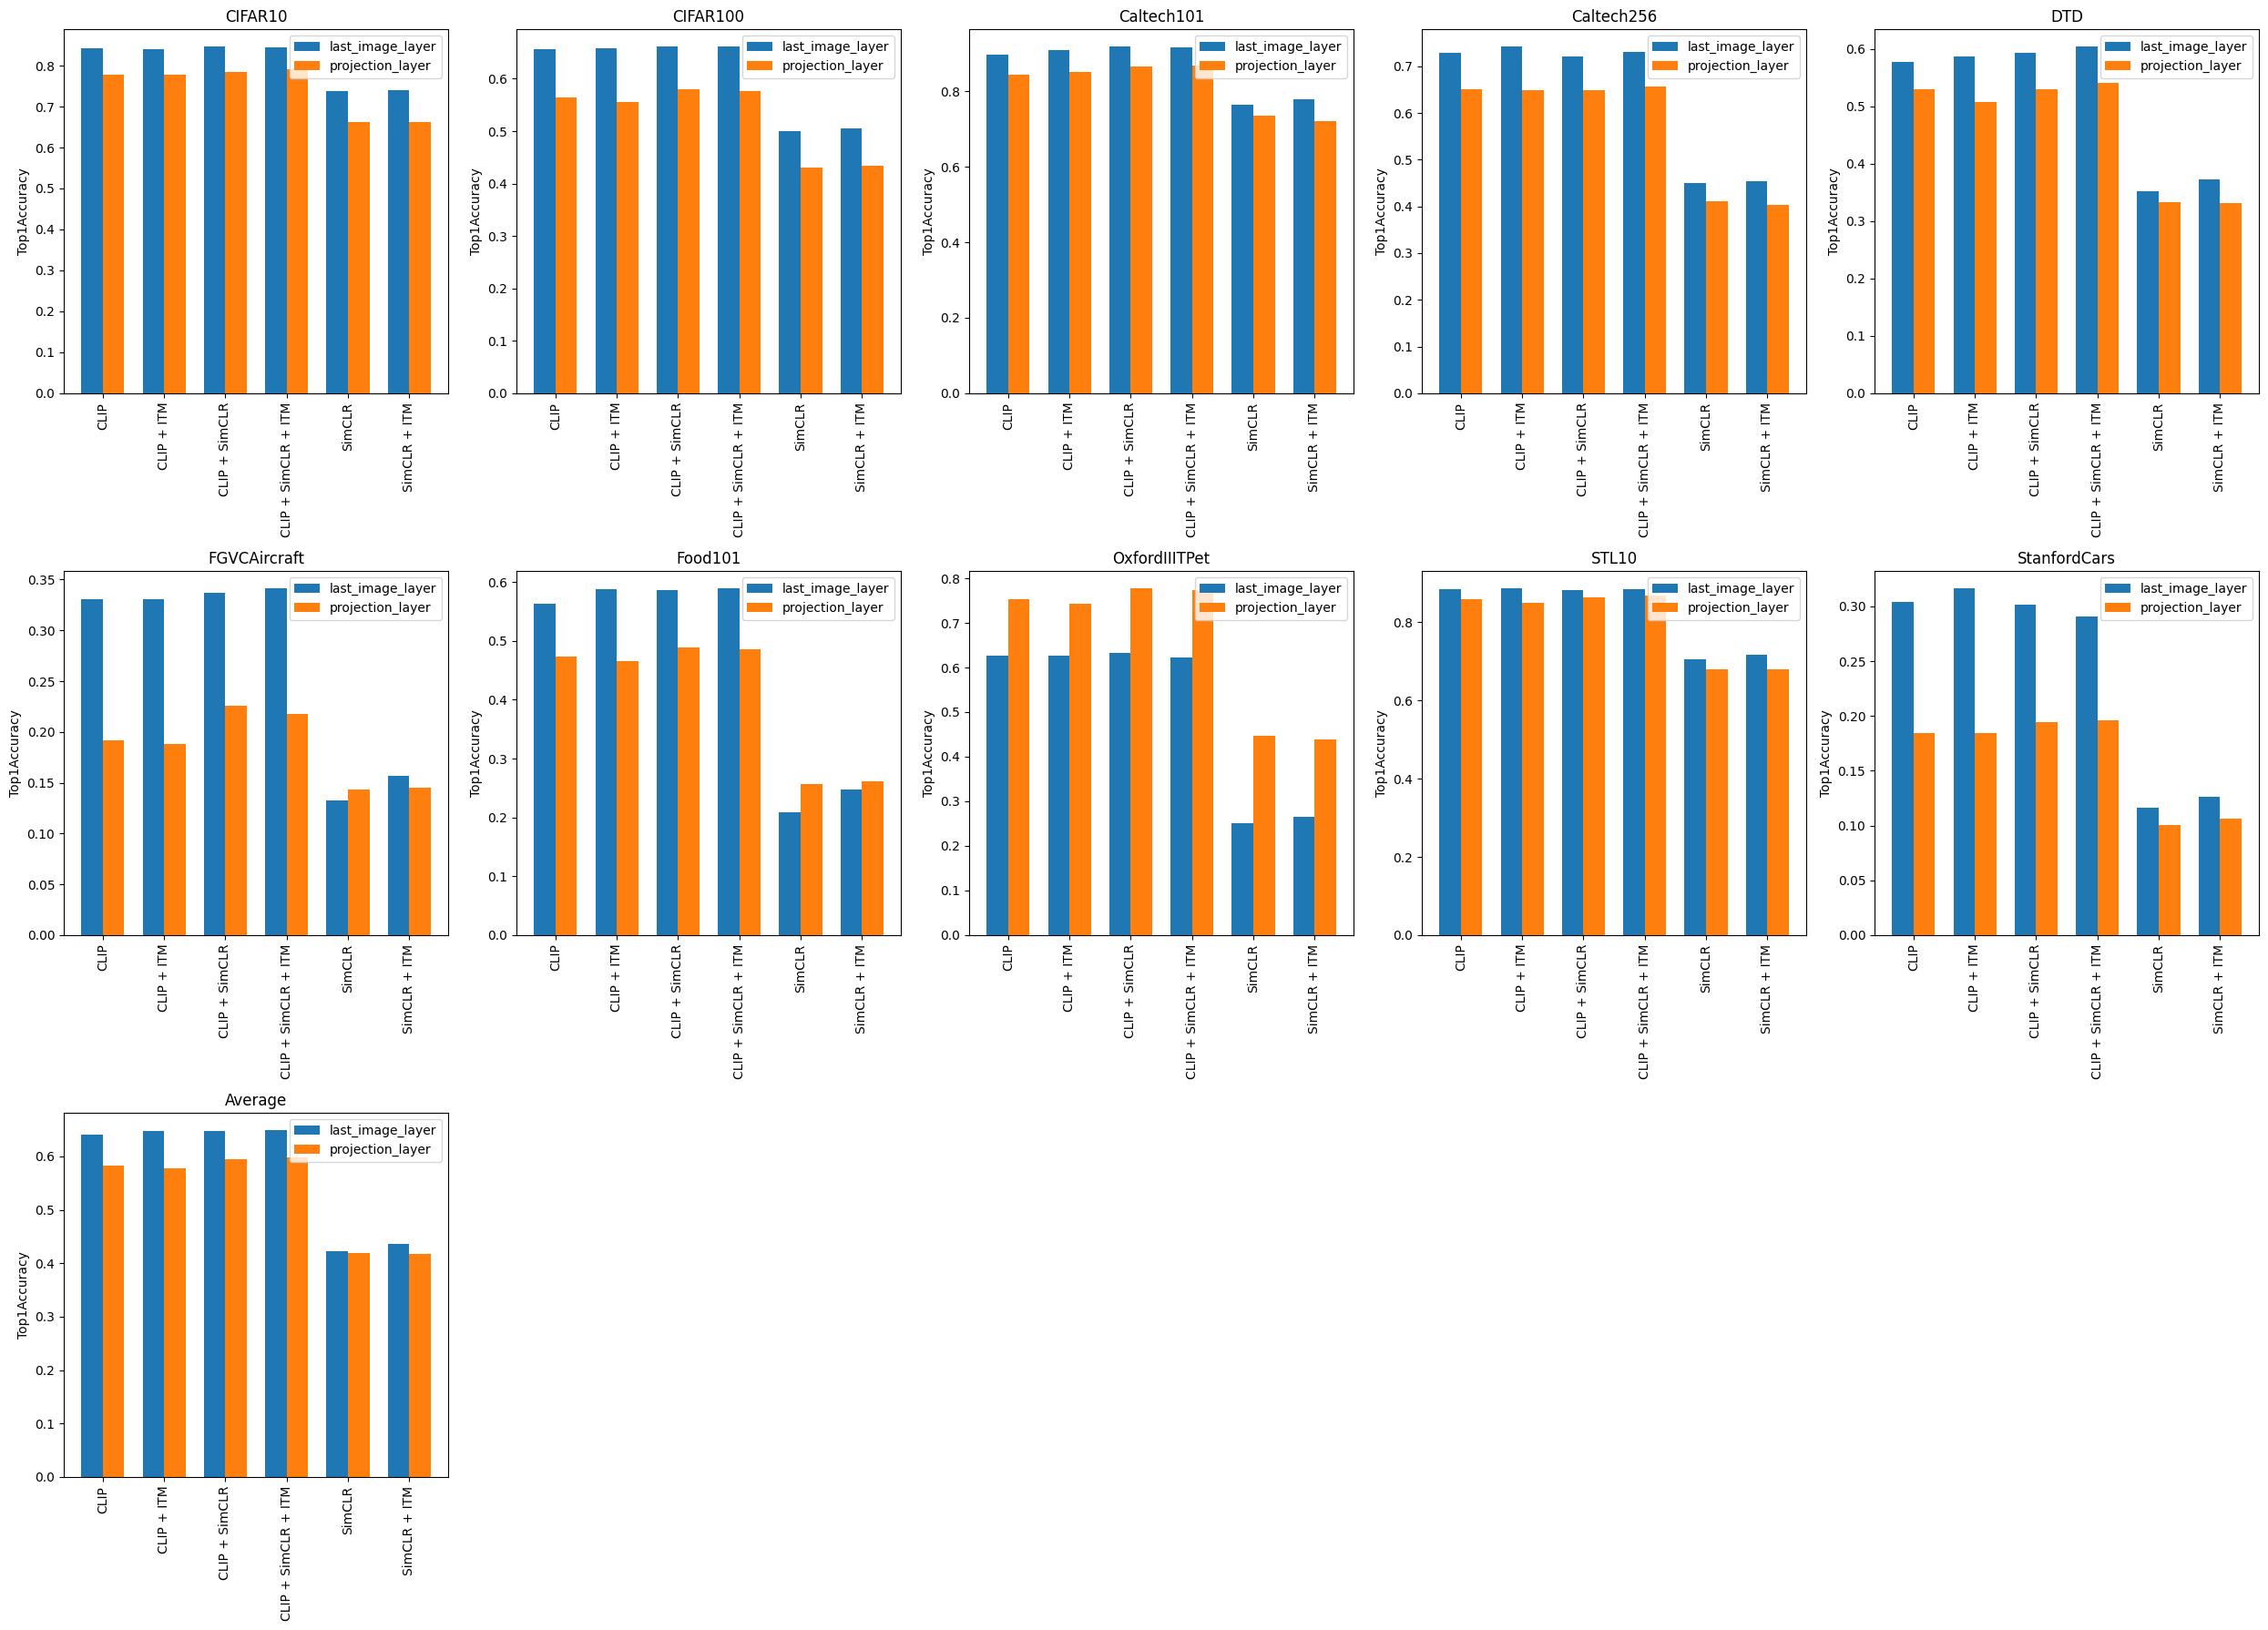

In [32]:
def plot_linear_probe_accuracies(
    last_image_layer_csv, 
    projection_layer_csv, 
    subset_fraction="1-aug", 
    metric='Top1Accuracy'
):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np

    # Load data
    df_last = pd.read_csv(last_image_layer_csv)
    df_proj = pd.read_csv(projection_layer_csv, comment='/', engine='python')  # skip commented lines

    second_layer_name = "projection_layer"
    # second_layer_name = "pooling_layer"

    # Filter by subset_fraction and metric
    df_last = df_last[(df_last['dataset_fraction'] == str(subset_fraction)) & (df_last['metric'] == metric)]
    df_proj = df_proj[(df_proj['dataset_fraction'] == str(subset_fraction)) & (df_proj['metric'] == metric) & (df_proj['method_notes'] == second_layer_name)]

    # Add a column to indicate representation type
    df_last['representation'] = 'last_image_layer'
    df_proj['representation'] = second_layer_name

    # Combine
    df_all = pd.concat([df_last, df_proj], ignore_index=True)

    # Only keep models/datasets for which both representations are available
    grouped = df_all.groupby(['dataset', 'model_name'])
    valid_keys = [
        key for key, group in grouped 
        if set(group['representation']) == {'last_image_layer', second_layer_name}
    ]
    df_all = df_all.set_index(['dataset', 'model_name'])
    df_plot = df_all.loc[valid_keys].reset_index()

    # Get unique datasets and models
    datasets = sorted(df_plot['dataset'].unique())
    models = sorted(df_plot['model_name'].unique())

    # Prepare for plotting
    n_datasets = len(datasets)
    ncols = 5
    nrows = int(np.ceil((n_datasets + 1) / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 6*nrows), squeeze=False)
    axes = axes.flatten()

    # For average subplot
    avg_data = []

    for i, dataset in enumerate(datasets):
        ax = axes[i]
        data = df_plot[df_plot['dataset'] == dataset]
        # Pivot to get [model_name][representation] = score
        pivot = data.pivot(index='model_name', columns='representation', values='score')
        # Only keep models with both representations
        pivot = pivot.dropna()
        x = np.arange(len(pivot))
        width = 0.35

        ax.bar(x - width/2, pivot['last_image_layer'], width, label='last_image_layer')
        ax.bar(x + width/2, pivot[second_layer_name], width, label=second_layer_name)
        ax.set_xticks(x)
        ax.set_xticklabels(pivot.index, rotation=90)
        ax.set_ylabel(metric)
        ax.set_title(dataset)
        ax.legend()

        avg_data.append(pivot)

    # Average subplot
    ax = axes[len(datasets)]
    if avg_data:
        avg_df = pd.concat(avg_data)
        avg_scores = avg_df.groupby('model_name').mean()
        x = np.arange(len(avg_scores))
        width = 0.35
        ax.bar(x - width/2, avg_scores['last_image_layer'], width, label='last_image_layer')
        ax.bar(x + width/2, avg_scores[second_layer_name], width, label=second_layer_name)
        ax.set_xticks(x)
        ax.set_xticklabels(avg_scores.index, rotation=90)
        ax.set_ylabel(metric)
        ax.set_title('Average')
        ax.legend()

    # Hide unused axes
    for j in range(len(datasets)+1, nrows*ncols):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

plot_linear_probe_accuracies(
    last_image_layer_csv='../../test_results/model_scores_linear_probe.csv',
    projection_layer_csv='../../test_results/model_scores_linear_probe_old.csv',
    subset_fraction=1.0  # or 1.0, etc.
)

# Linear probe vs zero-shot accuracy

In [80]:
def plot_linear_vs_zeroshot_per_model(
    df_linear,
    df_zeroshot,
    x_axis='linear',  # or 'zeroshot'
    dataset_fraction="1-aug",
    linear_method_notes='last_image_layer',
    zeroshot_method_notes='9_templates',
    zeroshot_mode="regular",
    metric='Top1Accuracy',
    model_id_col='model_id',
    dataset_order=None,
    figsize_per_row=4,
    figsize_per_col=5,
    has_clip=None  # NEW PARAMETER: True = only CLIP, False = only non-CLIP, None = all
):
    """
    Each subplot is a model, points are datasets, x/y are linear/zeroshot accuracy.
    Fits a regression line with 95% confidence interval.
    Subplot titles show model_name and r-value.
    has_clip: True = only models with 'CLIP' in name, False = only non-CLIP, None = all.
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import linregress, t

    # Filter dataframes
    df_linear = df_linear[
        (df_linear['dataset_fraction'] == str(dataset_fraction)) &
        (df_linear['method_notes'] == linear_method_notes) &
        (df_linear['metric'] == metric)
    ]
    df_zeroshot = df_zeroshot[
        (df_zeroshot['dataset_fraction'] == str(dataset_fraction))
        & (df_zeroshot['method_notes'] == zeroshot_method_notes)
        & (df_zeroshot['mode'] == zeroshot_mode)
        & (df_zeroshot['metric'] == metric)
    ]

    # Merge on model_id and dataset, keep model_name for title
    merged = pd.merge(
        df_linear[[model_id_col, 'model_name', 'dataset', 'score']].rename(columns={'score': 'linear'}),
        df_zeroshot[[model_id_col, 'model_name', 'dataset', 'score']].rename(columns={'score': 'zeroshot'}),
        on=[model_id_col, 'dataset'],
        how='inner',
        suffixes=('_linear', '_zeroshot')
    )
    # Use model_name from linear (should be the same)
    merged['model_name'] = merged['model_name_linear']

    # Filter by has_clip if requested
    if has_clip is True:
        merged = merged[merged['model_name'].str.contains('CLIP', case=False, na=False)]
    elif has_clip is False:
        merged = merged[~merged['model_name'].str.contains('CLIP', case=False, na=False)]

    models = merged[model_id_col].unique()
    n_models = len(models)
    ncols = 3
    nrows = int(np.ceil(n_models / ncols))
    fig, axes = plt.subplots(nrows, ncols, figsize=(figsize_per_col*ncols, figsize_per_row*nrows), squeeze=False)

    for i, model_id in enumerate(models):
        ax = axes[i // ncols, i % ncols]
        data = merged[merged[model_id_col] == model_id]
        model_name = data['model_name'].iloc[0] if not data.empty else model_id
        # Sort datasets for consistent plotting
        if dataset_order is not None:
            data = data.set_index('dataset').reindex(dataset_order).dropna(subset=[x_axis, 'zeroshot' if x_axis == 'linear' else 'linear']).reset_index()
        else:
            data = data.dropna(subset=[x_axis, 'zeroshot' if x_axis == 'linear' else 'linear'])
        if data.empty:
            ax.set_title(model_name)
            ax.axis('off')
            continue
        x = data[x_axis].values
        y = data['zeroshot' if x_axis == 'linear' else 'linear'].values
        labels = data['dataset'].values

        # Scatter points
        ax.scatter(x, y, color='C0')
        for xi, yi, label in zip(x, y, labels):
            ax.annotate(label, (xi, yi), fontsize=8, alpha=0.7)

        # Fit regression line and 95% confidence interval
        r_value = None
        if len(x) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            x_fit = np.linspace(np.min(x), np.max(x), 100)
            y_fit = slope * x_fit + intercept

            # 95% confidence interval calculation
            n = len(x)
            y_pred = slope * x + intercept
            residuals = y - y_pred
            dof = n - 2
            t_val = t.ppf(0.975, dof) if dof > 0 else 1.96  # fallback to normal
            s_err = np.sqrt(np.sum(residuals**2) / dof) if dof > 0 else 0
            mean_x = np.mean(x)
            confs = []
            for xf in x_fit:
                se = s_err * np.sqrt(1/n + (xf - mean_x)**2 / np.sum((x - mean_x)**2)) if dof > 0 else 0
                confs.append(t_val * se)
            confs = np.array(confs)
            ax.plot(x_fit, y_fit, color='C1', label=f"fit")
            ax.fill_between(x_fit, y_fit - confs, y_fit + confs, color='C1', alpha=0.2, label='95% CI')

        # Add x=y line
        min_xy = min(np.min(x), np.min(y))
        max_xy = max(np.max(x), np.max(y))
        xy_line = np.linspace(min_xy, max_xy, 100)
        ax.plot(xy_line, xy_line, linestyle='--', color='grey', alpha=0.7, label='x=y')

        # Add r-value to the title if available
        if r_value is not None:
            ax.set_title(f"{model_name}\nr = {r_value:.2f}")
        else:
            ax.set_title(model_name)
        ax.set_xlabel(f"{x_axis.capitalize()} accuracy")
        ax.set_ylabel(f"{'zeroshot' if x_axis == 'linear' else 'linear'} accuracy")
        ax.legend(fontsize='small')

    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

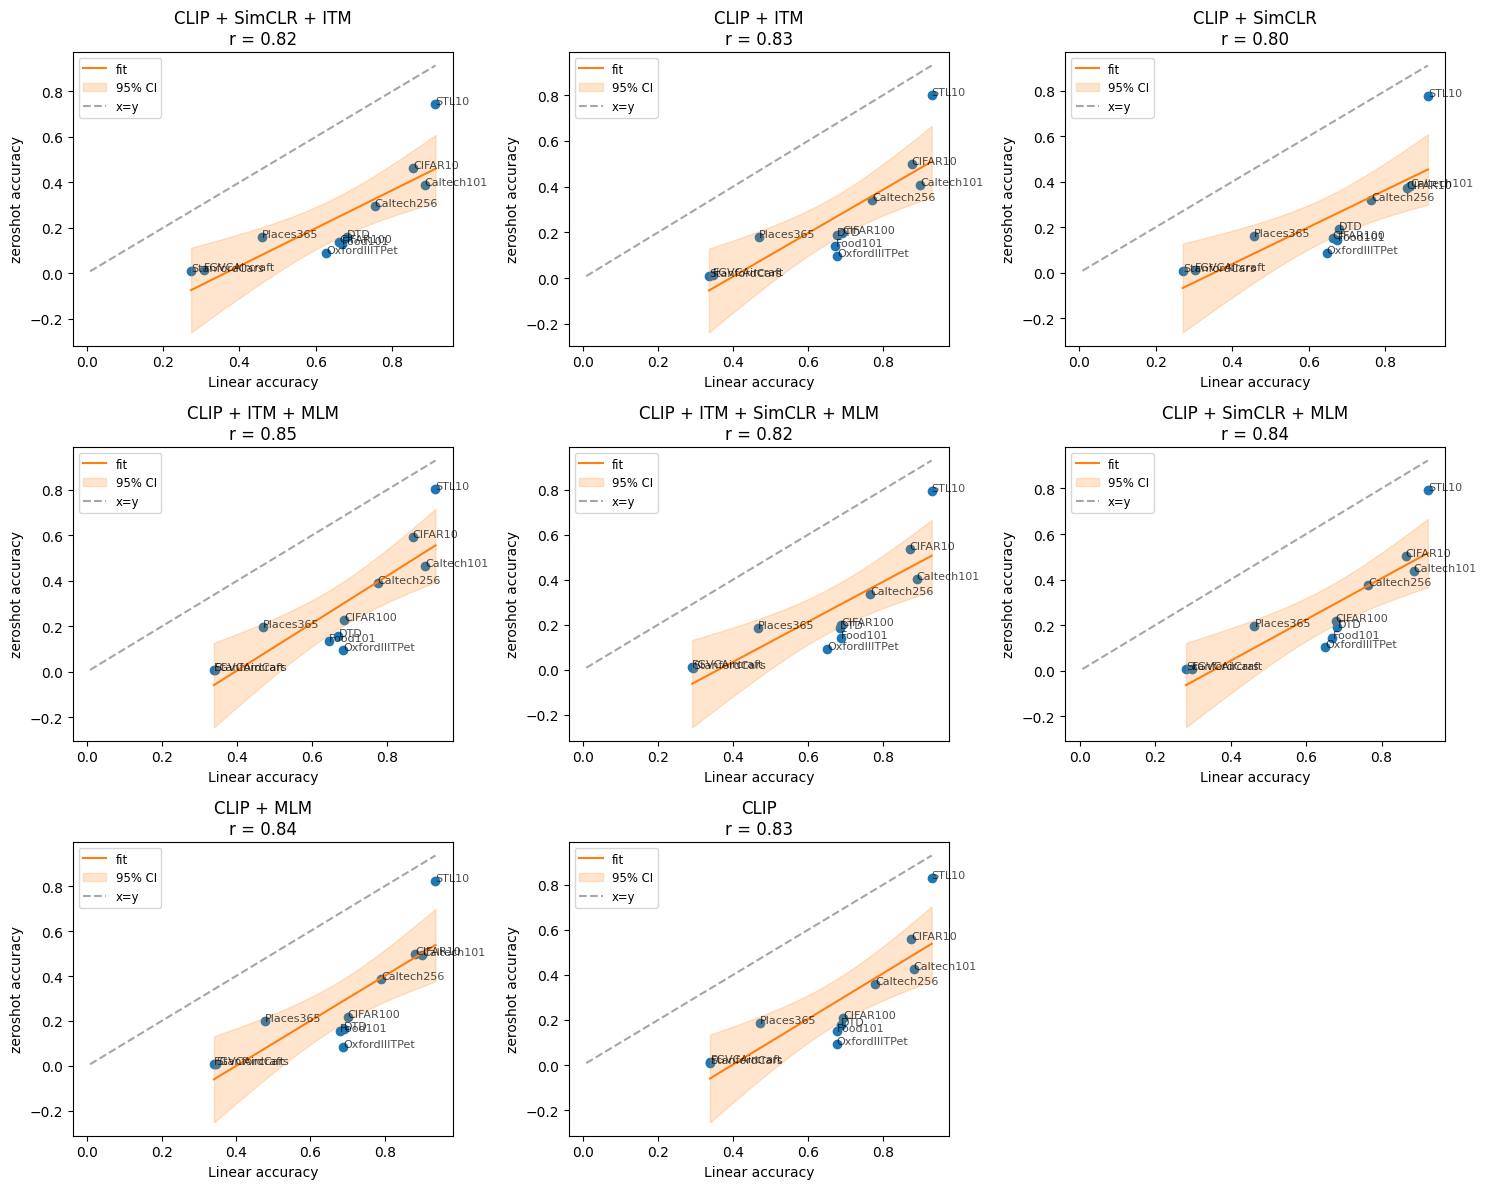

In [83]:
df_linear = pd.read_csv('../../test_results/model_scores_linear_probe.csv')
df_zeroshot = pd.read_csv('../../test_results/model_scores_zero-shot.csv')

plot_linear_vs_zeroshot_per_model(
    df_linear,
    df_zeroshot,
    x_axis='linear',
    dataset_fraction="1-aug",
    linear_method_notes='last_image_layer',
    zeroshot_method_notes="9_templates",
    has_clip=True
)

In [86]:
def plot_linear_vs_zeroshot_all_models_one_chart(
    df_linear,
    df_zeroshot,
    x_axis='linear',  # or 'zeroshot'
    dataset_fraction="1-aug",
    linear_method_notes='last_image_layer',
    zeroshot_method_notes='9_templates',
    zeroshot_mode="regular",
    metric='Top1Accuracy',
    model_id_col='model_id',
    model_name_col='model_name',
    dataset_order=None,
    figsize=(8, 6),
    legend_loc='best'
):
    """
    Plots all models in one chart.
    - Each model is a different color and marker.
    - Each point is a dataset for a model.
    - Fits a regression line for each model (with 95% CI shaded).
    - Adds x=y line (dashed grey).
    """
    import matplotlib.pyplot as plt
    import numpy as np
    import seaborn as sns
    from scipy.stats import linregress, t

    # Use a set of distinct markers
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '8', '<', '>', 'p', 'H', 'd']
    
    # Filter dataframes
    df_linear = df_linear[
        (df_linear['dataset_fraction'] == str(dataset_fraction)) &
        (df_linear['method_notes'] == linear_method_notes) &
        (df_linear['metric'] == metric)
    ]
    df_zeroshot = df_zeroshot[
        (df_zeroshot['dataset_fraction'] == str(dataset_fraction))
        & (df_zeroshot['method_notes'] == zeroshot_method_notes)
        & (df_zeroshot['mode'] == zeroshot_mode)
        & (df_zeroshot['metric'] == metric)
    ]

    # Merge on model_id and dataset, keep model_name for legend
    merged = pd.merge(
        df_linear[[model_id_col, model_name_col, 'dataset', 'score']].rename(columns={'score': 'linear'}),
        df_zeroshot[[model_id_col, model_name_col, 'dataset', 'score']].rename(columns={'score': 'zeroshot'}),
        on=[model_id_col, 'dataset'],
        how='inner',
        suffixes=('_linear', '_zeroshot')
    )
    # Use model_name from linear (should be the same)
    merged['model_name'] = merged[f'{model_name_col}_linear']

    models = merged[model_id_col].unique()
    model_names = merged.drop_duplicates(model_id_col).set_index(model_id_col)['model_name'].to_dict()
    palette = sns.color_palette('tab20', n_colors=len(models))
    color_map = {mid: palette[i % len(palette)] for i, mid in enumerate(models)}
    marker_map = {mid: markers[i % len(markers)] for i, mid in enumerate(models)}

    plt.figure(figsize=figsize)
    min_xy, max_xy = np.inf, -np.inf

    for i, model_id in enumerate(models):
        data = merged[merged[model_id_col] == model_id]
        model_name = model_names[model_id]
        # Sort datasets for consistent plotting
        if dataset_order is not None:
            data = data.set_index('dataset').reindex(dataset_order).dropna(subset=[x_axis, 'zeroshot' if x_axis == 'linear' else 'linear']).reset_index()
        else:
            data = data.dropna(subset=[x_axis, 'zeroshot' if x_axis == 'linear' else 'linear'])
        if data.empty:
            continue
        x = data[x_axis].values
        y = data['zeroshot' if x_axis == 'linear' else 'linear'].values
        labels = data['dataset'].values

        # Track min/max for x=y line
        min_xy = min(min_xy, np.min(x), np.min(y))
        max_xy = max(max_xy, np.max(x), np.max(y))

        # Scatter points with unique marker per model
        plt.scatter(
            x, y,
            color=color_map[model_id],
            marker=marker_map[model_id],
            label=model_name,
            alpha=0.8,
            edgecolor='black',
            s=60
        )
        # Optionally annotate points
        # for xi, yi, label in zip(x, y, labels):
        #     plt.annotate(label, (xi, yi), fontsize=8, alpha=0.7, color=color_map[model_id])

        # Fit regression line and 95% CI
        if len(x) > 1:
            slope, intercept, r_value, p_value, std_err = linregress(x, y)
            x_fit = np.linspace(np.min(x), np.max(x), 100)
            y_fit = slope * x_fit + intercept

            # 95% confidence interval
            n = len(x)
            y_pred = slope * x + intercept
            residuals = y - y_pred
            dof = n - 2
            t_val = t.ppf(0.975, dof) if dof > 0 else 1.96
            s_err = np.sqrt(np.sum(residuals**2) / dof) if dof > 0 else 0
            mean_x = np.mean(x)
            confs = []
            for xf in x_fit:
                se = s_err * np.sqrt(1/n + (xf - mean_x)**2 / np.sum((x - mean_x)**2)) if dof > 0 else 0
                confs.append(t_val * se)
            confs = np.array(confs)
            plt.plot(x_fit, y_fit, color=color_map[model_id], alpha=0.8, linewidth=2)
            # plt.fill_between(x_fit, y_fit - confs, y_fit + confs, color=color_map[model_id], alpha=0.18)

    # Add x=y line
    if min_xy < max_xy:
        xy_line = np.linspace(min_xy, max_xy, 100)
        plt.plot(xy_line, xy_line, linestyle='--', color='grey', alpha=0.7, label='x=y')

    plt.xlabel(f"{x_axis.capitalize()} accuracy")
    plt.ylabel(f"{'zeroshot' if x_axis == 'linear' else 'linear'} accuracy")
    plt.title("Linear vs Zeroshot Accuracy (All Models)")
    handles, labels = plt.gca().get_legend_handles_labels()
    # Remove duplicate model names in legend
    from collections import OrderedDict
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), loc=legend_loc, fontsize='small')
    plt.tight_layout()
    plt.show()

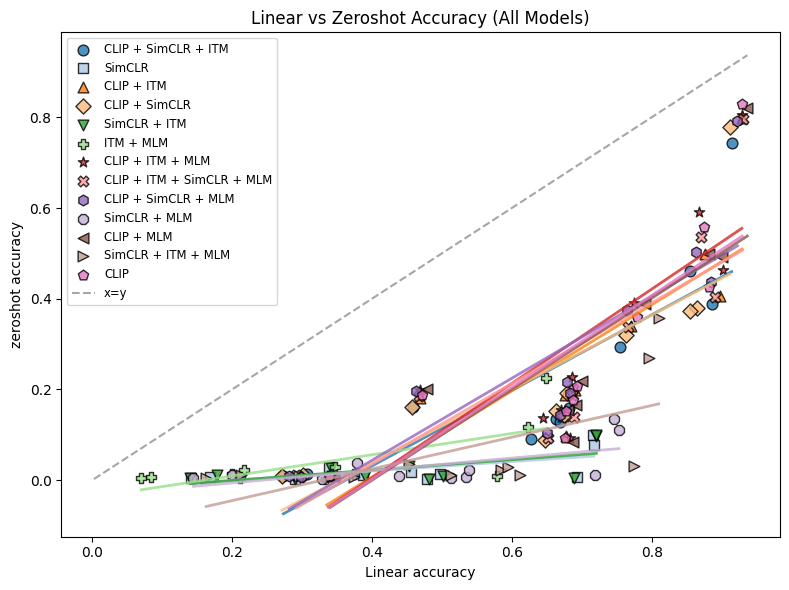

In [87]:
df_linear = pd.read_csv('../../test_results/model_scores_linear_probe.csv')
df_zeroshot = pd.read_csv('../../test_results/model_scores_zero-shot.csv')

plot_linear_vs_zeroshot_all_models_one_chart(
    df_linear,
    df_zeroshot,
    x_axis='linear',
    dataset_fraction="1-aug",
    linear_method_notes='last_image_layer',
    zeroshot_method_notes="9_templates"
)

In [97]:
def plot_linear_vs_zeroshot(
    df_linear,
    df_zeroshot,
    x_axis='linear',  # or 'zeroshot'
    dataset_fraction=1.0,
    linear_method_notes='last_image_layer',
    zeroshot_method_notes='zeroshot',
    zeroshot_mode='regular',
    metric='Top1Accuracy',
    datasets_to_plot="actual",  # "actual" or "average"
    dataset_subsets_dict=None   # dict: {subset_name: [dataset1, dataset2, ...]}
):
    """
    Plots linear probe vs zero-shot accuracy for each dataset, with each model as a line.
    Adds x=y line to each subplot.
    Uses model_name for legend labels.
    datasets_to_plot: "actual" (each dataset separately), "average" (average over subsets in dataset_subsets_dict)
    dataset_subsets_dict: dict of {subset_name: [datasets]} for averaging if datasets_to_plot="average"
    """
    import numpy as np
    import matplotlib.pyplot as plt

    # Filter dataframes
    df_linear = df_linear[
        (df_linear['dataset_fraction'] == dataset_fraction) &
        (df_linear['method_notes'] == linear_method_notes) &
        (df_linear['metric'] == metric)
    ]
    df_zeroshot = df_zeroshot[
        (df_zeroshot['dataset_fraction'] == dataset_fraction) &
        (df_zeroshot['method_notes'] == zeroshot_method_notes) &
        (df_zeroshot['mode'] == 'regular') &
        (df_zeroshot['metric'] == metric)
    ]

    # Merge on model_id and dataset, keep model_name for labeling
    merged = pd.merge(
        df_linear[['model_id', 'model_name', 'dataset', 'score']].rename(columns={'score': 'linear'}),
        df_zeroshot[['model_id', 'model_name', 'dataset', 'score']].rename(columns={'score': 'zeroshot'}),
        on=['model_id', 'dataset'],
        how='inner',
        suffixes=('_linear', '_zeroshot')
    )
    # Use model_name from linear (should be the same as zeroshot)
    merged['model_name'] = merged['model_name_linear']

    if datasets_to_plot == "average":
        if dataset_subsets_dict is None:
            raise ValueError("dataset_subsets_dict must be provided for average plotting.")
        # Compute averages for each subset
        avg_rows = []
        for subset_name, subset_datasets in dataset_subsets_dict.items():
            subset = merged[merged['dataset'].isin(subset_datasets)]
            if subset.empty:
                continue
            grouped = subset.groupby(['model_id', 'model_name']).agg({'linear': 'mean', 'zeroshot': 'mean'}).reset_index()
            grouped['dataset'] = subset_name
            avg_rows.append(grouped)
        merged = pd.concat(avg_rows, ignore_index=True)
        datasets = list(dataset_subsets_dict.keys())
    else:
        datasets = sorted(merged['dataset'].unique())

    models = merged['model_id'].unique()
    model_name_map = merged.drop_duplicates('model_id').set_index('model_id')['model_name'].to_dict()

    n_datasets = len(datasets)
    ncols = 3
    nrows = (n_datasets + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(5*ncols, 4*nrows), squeeze=False)

    # Use different markers for models
    markers = ['o', 's', '^', 'D', 'v', 'P', '*', 'X', 'h', '8', '<', '>', 'p', 'H', 'd']
    marker_map = {mid: markers[i % len(markers)] for i, mid in enumerate(models)}

    for i, dataset in enumerate(datasets):
        ax = axes[i // ncols, i % ncols]
        data = merged[merged['dataset'] == dataset]
        min_xy, max_xy = float('inf'), float('-inf')
        for model_id in models:
            model_data = data[data['model_id'] == model_id]
            if model_data.empty:
                continue
            x = model_data[x_axis]
            y = model_data['zeroshot' if x_axis == 'linear' else 'linear']
            label = model_name_map.get(model_id, str(model_id))
            ax.plot(x, y, marker=marker_map[model_id], label=label)
            min_xy = min(min_xy, x.min(), y.min())
            max_xy = max(max_xy, x.max(), y.max())
        # Add x=y line
        if min_xy < max_xy:
            xy_line = np.linspace(min_xy, max_xy, 100)
            ax.plot(xy_line, xy_line, linestyle='--', color='grey', alpha=0.7, label='x=y')
        ax.set_title(dataset)
        ax.set_xlabel(f"{x_axis.capitalize()} probe accuracy")
        ax.set_ylabel(f"{'zeroshot' if x_axis == 'linear' else 'linear'} accuracy")
        ax.legend(fontsize='small')

    # Hide unused subplots
    for j in range(i+1, nrows*ncols):
        axes[j // ncols, j % ncols].axis('off')

    plt.tight_layout()
    plt.show()

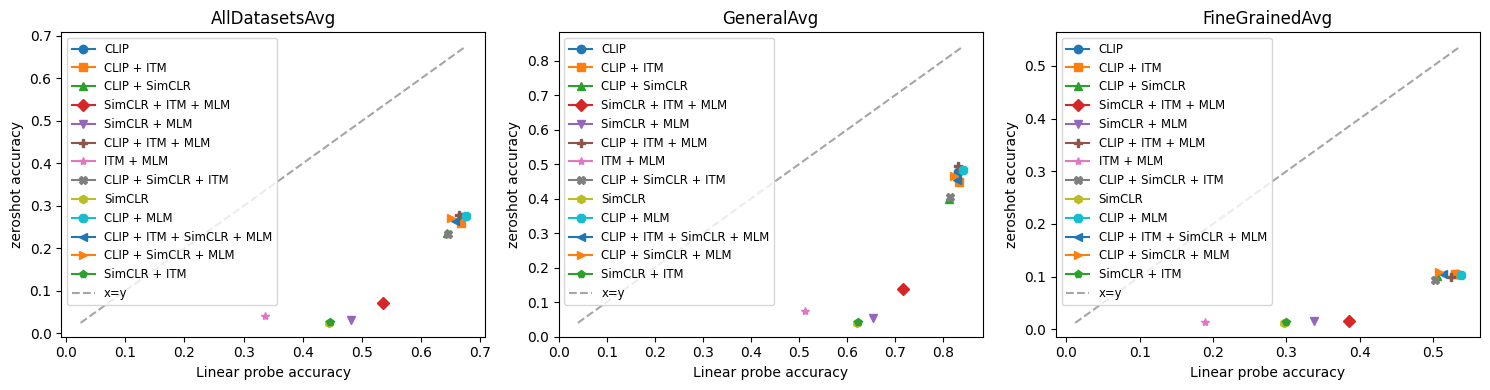

In [102]:
plot_linear_vs_zeroshot(
    df_linear,
    df_zeroshot,
    x_axis='linear',
    dataset_fraction="1-aug",
    linear_method_notes='last_image_layer',
    zeroshot_method_notes='9_templates',
    zeroshot_mode='regular',
    datasets_to_plot="average",  # or "actual"
    dataset_subsets_dict=dataset_subsets_dict,
)

# Old

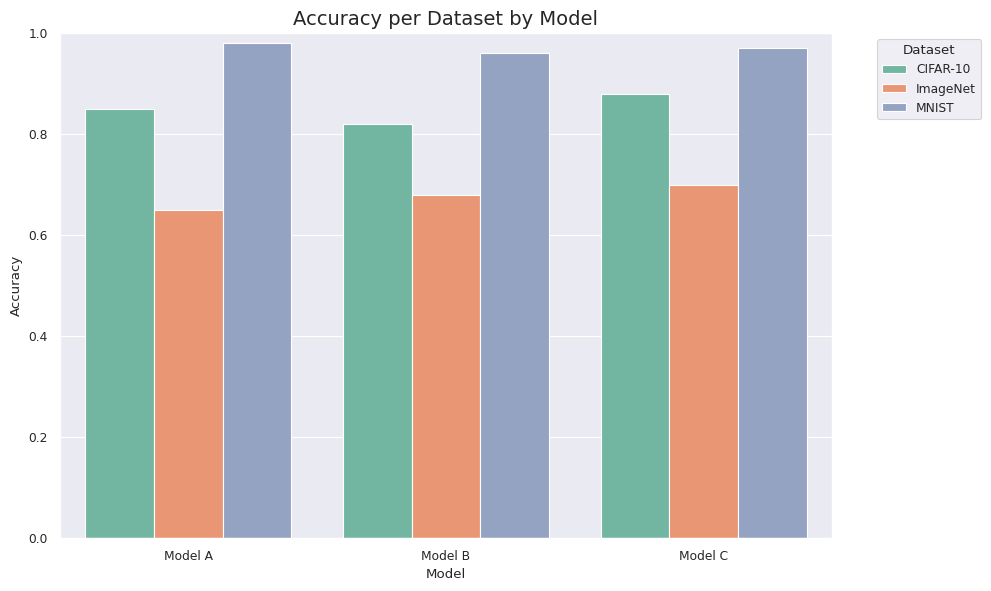

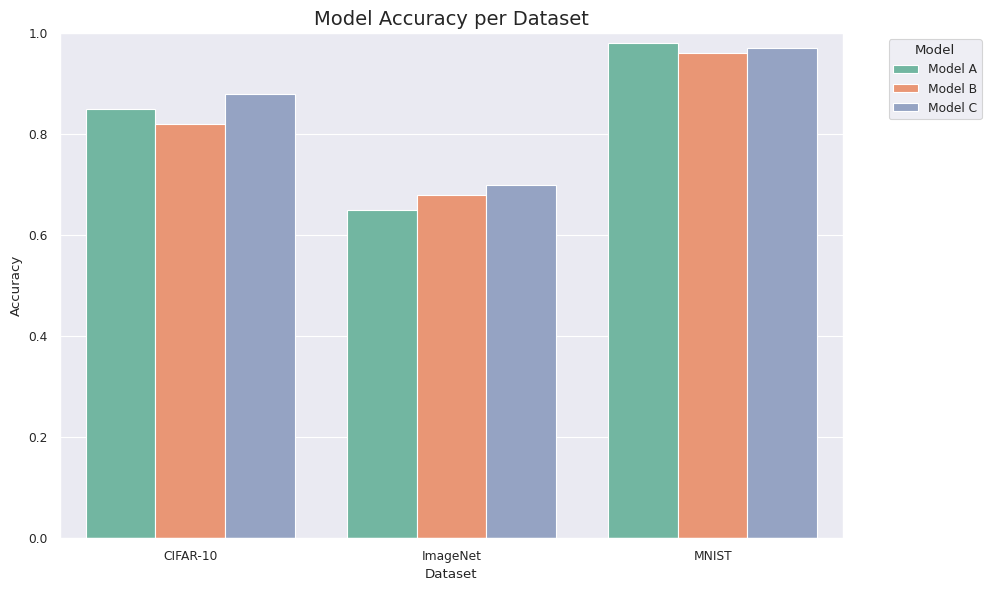

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_results(data, metric='accuracy', title='Model Performance', orientation='model', save_path=None):
    """
    Generate a grouped bar plot for model performance across datasets.

    Parameters:
        data (dict): Nested dictionary of the form:
                     {
                         'ModelA': {'Dataset1': val, 'Dataset2': val, ...},
                         'ModelB': {'Dataset1': val, 'Dataset2': val, ...},
                         ...
                     }
        metric (str): Metric name to display on y-axis (e.g., 'accuracy').
        title (str): Plot title.
        orientation (str): 'model' for models on x-axis, 'dataset' for datasets on x-axis.
        save_path (str): If set, saves the figure to this path.
    """
    # Convert nested dict to long-form DataFrame
    df = (
        pd.DataFrame(data)
        .T
        .reset_index()
        .melt(id_vars='index', var_name='Dataset', value_name=metric)
        .rename(columns={'index': 'Model'})
    )

    # Choose axis based on orientation
    if orientation not in {'model', 'dataset'}:
        raise ValueError("Orientation must be 'model' or 'dataset'")

    x = 'Model' if orientation == 'model' else 'Dataset'
    hue = 'Dataset' if orientation == 'model' else 'Model'

    # Set theme and create plot
    sns.set_theme(style='darkgrid', context='paper')
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=df, x=x, y=metric, hue=hue, palette='Set2')

    # Titles and labels
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(metric.capitalize())
    ax.set_xlabel(x)
    ax.set_ylim(0, 1)  # adjust if needed
    plt.legend(title=hue, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path)
        print(f"Plot saved to {save_path}")
    else:
        plt.show()

# Example usage
if __name__ == '__main__':
    results = {
        'Model A': {'CIFAR-10': 0.85, 'ImageNet': 0.65, 'MNIST': 0.98},
        'Model B': {'CIFAR-10': 0.82, 'ImageNet': 0.68, 'MNIST': 0.96},
        'Model C': {'CIFAR-10': 0.88, 'ImageNet': 0.70, 'MNIST': 0.97}
    }

    # Plot with models on x-axis
    plot_results(results, orientation='model', title='Accuracy per Dataset by Model')

    # Plot with datasets on x-axis
    plot_results(results, orientation='dataset', title='Model Accuracy per Dataset')
